# Project 1: Great Places To Visit And Invest
### A Data Analysis of Great Places To Visit And Invest

#### By Karoly Burgyan, Shayla Badeaux, Christian Cantu
 This project investigates which countries would be good for investment from the perspective of a United States based real estate company or travel agency that is ready to go international in their investments. The project asks the 5 following questions:

1. Is there a correlation between Happiness and Safety?
2. Is there a correlation between Happiness and Cost of Living?
3. Is there a correlation between Happiness and Purchasing Power?
4. Which countries satisfy the priorities of the customer best-- does the customer value happiness, purchasing power, or safety most?
5. Which countries on the priority lists have the most developed infrastructure using GDP as a proxy for infrastructure development?

To answer these five questions, datasets on happiness, cost of living (which included purchasing power), crime (safety), and gross domestic product were combined to reach the conclusions that there are 17 excellent country choices for investment: Australia, Austria, Bahrain, Canada, Denmark, Estonia, Finland, Germany, Israel, Japan, Netherlands, New Zealand, Suadi Arabia, Singapore, Slovenia, Sweden, and United Arab Emirates. And of these, the top 5 are Saudi Arabia, Israel, Slovenia, United Arab Emirates, and Austria.

#### Gathering, Exploring, and Analyzing the Data
1. Datasets for happiness, cost of living (which included purchasing power), and crime (safety) were merged together producing one large merged dataset.<br>
2. The safety index across each country was stated by city and so, to get a rough estimation of the country-wide safety index, the safety index across all the cities in a country were combined into an averaged for the country.
3. The statistical outliers of the merged dataset for the values of happiness, cost of living, purchasing power, and safety were attributed to error in measurement and were removed from the dataset.<br>
4. Correlations between happiness and safety, happiness and cost of living, and happiness and purchasing power were calculated using linear regressions. These correlations were 0.35, 0.74, and 0.74 respectively.<br>
5. Because purchasing power had the same correlation to happiness as cost of living and it has more salience in terms of investing from the perspective of real estate companies and travel agencies, the cost of living was determined to be less useful and perhaps redundant in the presence of purchasing power.<br>
6. Z-scores were calculated for the happiness, safety, and purchasing power to assess whether the values varied sufficiently to assess the importance of each metric. If the z-scores were small (eg less than 1 standard deviation) for a metric, then it could be assumed that the metric was less relevant in comparison to the other two metrics.<br>
7. 3D plots were created to visualize the z-scores and assess their variability. It turned out that all three metrics varied well beyond 1 standard deviation and, thereby, suggesting that each metric represented a tangible difference across the countries that shouldn't be discarded.<br>
8. From the 3 metrics happiness, safety, and purchasing power, the following 7 different prioritization combinations were considered and a histogram for each prioritization was created:<br>
&emsp;&emsp;i. Equally weighted happiness, safety, and purchasing power<br>
&emsp;&emsp;ii. Prioritized happiness, safety, then purchasing power<br>
&emsp;&emsp;iii. Prioritized happiness, purchasing power, then safety<br>
&emsp;&emsp;iv. Prioritized safety, happiness, then purchasing power<br>
&emsp;&emsp;v. Prioritized safety, purchasing power, then happiness<br>
&emsp;&emsp;vi. Prioritized purchasing power, safety, then happiness<br>
&emsp;&emsp;vii. Prioritized purchasing power, happiness, then safety<br>

9. From those 7 prioritizations, a total of 17 unique countries were collected.<br>
10. A new dataset of Gross Domestic Product by country by year was introduced as a proxy for a comparison of growth of infrastructure among the 17 unique countries.<br>
11. A line plot showing the last 5 years of the top 17 countries revealed that top 5 growing countries were Saudi Arabia, Israel, Slovenia, United Arab Emirates, and Austria.<br>



In [1]:
# Dependencies and Setup
import hvplot.pandas
import holoviews
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json
import datetime
import csv
import mplcursors

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy

# Import API key 
from api_keys import geoapify_key

# Stretch Jupyter to a greater width
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
# Read in Happiness dataset and Cost of living dataset
hap_df = pd.read_csv('./Resources/2022.csv')
hap_df = hap_df[['Country', 'Happiness score']]
hap_df.columns = ['Country', 'Happiness Score']
cost_df = pd.read_csv('./Resources/Cost_of_Living_Index_2022.csv')
cost_df = cost_df[['Country', 'Local Purchasing Power Index', 'Cost of Living Index']]

print(hap_df.head())
cost_df.head()

       Country Happiness Score
0      Finland           7,821
1      Denmark           7,636
2      Iceland           7,557
3  Switzerland           7,512
4  Netherlands           7,415


Country  Local Purchasing Power Index  Cost of Living Index
0  Afghanistan                         23.04                 20.37
1      Albania                         30.19                 35.50
2      Algeria                         24.63                 26.87
3    Argentina                         30.72                 34.69
4      Armenia                         28.86                 33.89

In [3]:
# Merging happiness and cost of living dataframes
HappinessCostOfLiving_df = hap_df.merge(cost_df, how='inner', on='Country')
HappinessCostOfLiving_df.head()

Country Happiness Score  Local Purchasing Power Index  \
0      Finland           7,821                         91.02   
1      Denmark           7,636                         99.45   
2      Iceland           7,557                         77.06   
3  Switzerland           7,512                        118.44   
4  Netherlands           7,415                         87.99   

   Cost of Living Index  
0                 73.20  
1                 84.12  
2                 94.86  
3                123.35  
4                 75.66

In [4]:
# Country Count
HappinessCostOfLiving_df.count()

Country                         106
Happiness Score                 106
Local Purchasing Power Index    106
Cost of Living Index            106
dtype: int64

In [5]:
# Read in Country and Capital dataset to get longitude and latitude
capCoord_df = pd.read_csv('./Resources/country-capitals.csv', on_bad_lines='skip')
print(capCoord_df.columns)
del capCoord_df['CountryCode']
del capCoord_df['ContinentName']
capCoord_df.columns = ['Country', 'Capital', 'Latitude', 'Longitude']
print(capCoord_df.columns)

capCoord_df.head()

Index(['CountryName', 'CapitalName', 'CapitalLatitude', 'CapitalLongitude',
       'CountryCode', 'ContinentName'],
      dtype='object')
Index(['Country', 'Capital', 'Latitude', 'Longitude'], dtype='object')


Country            Capital   Latitude  \
0                                Somaliland           Hargeisa   9.550000   
1  South Georgia and South Sandwich Islands  King Edward Point -54.283333   
2       French Southern and Antarctic Lands  Port-aux-Français -49.350000   
3                                 Palestine          Jerusalem  31.766667   
4                             Aland Islands          Mariehamn  60.116667   

   Longitude  
0  44.050000  
1 -36.500000  
2  70.216667  
3  35.233333  
4  19.900000

In [6]:
# Merge long and latitude to HappinessCostOfLiving_df
HappinessCostOfLiving_df = HappinessCostOfLiving_df.merge(capCoord_df, how='inner', on='Country')
HappinessCostOfLiving_df.head()

Country Happiness Score  Local Purchasing Power Index  \
0      Finland           7,821                         91.02   
1      Denmark           7,636                         99.45   
2      Iceland           7,557                         77.06   
3  Switzerland           7,512                        118.44   
4  Netherlands           7,415                         87.99   

   Cost of Living Index     Capital   Latitude  Longitude  
0                 73.20    Helsinki  60.166667  24.933333  
1                 84.12  Copenhagen  55.666667  12.583333  
2                 94.86   Reykjavik  64.150000 -21.950000  
3                123.35        Bern  46.916667   7.466667  
4                 75.66   Amsterdam  52.350000   4.916667

In [7]:
# Change Happiness Score from object to float
HappinessCostOfLiving_df['Happiness Score'] = HappinessCostOfLiving_df['Happiness Score'].str.replace(",", "").astype('float')
HappinessCostOfLiving_df.dtypes


Country                          object
Happiness Score                 float64
Local Purchasing Power Index    float64
Cost of Living Index            float64
Capital                          object
Latitude                        float64
Longitude                       float64
dtype: object

In [8]:
# Sort Countries by "Country"
srt_df= HappinessCostOfLiving_df.sort_values(by='Country')
print(HappinessCostOfLiving_df.count())
srt_df.head()

Country                         103
Happiness Score                 103
Local Purchasing Power Index    103
Cost of Living Index            103
Capital                         103
Latitude                        103
Longitude                       103
dtype: int64


Country  Happiness Score  Local Purchasing Power Index  \
102  Afghanistan           2404.0                         23.04   
72       Albania           5199.0                         30.19   
75       Algeria           5122.0                         24.63   
49     Argentina           5967.0                         30.72   
68       Armenia           5399.0                         28.86   

     Cost of Living Index       Capital   Latitude  Longitude  
102                 20.37         Kabul  34.516667  69.183333  
72                  35.50        Tirana  41.316667  19.816667  
75                  26.87       Algiers  36.750000   3.050000  
49                  34.69  Buenos Aires -34.583333 -58.666667  
68                  33.89       Yerevan  40.166667  44.500000

In [9]:
# Save dataFrame to csv
HappinessCostOfLiving_df.to_csv('./Output/CSVSavePoint/HappinessCostOfLiving_df.csv')

In [10]:
#********************************************
# Create a dataframe loading point in order to skip steps in the event of having to restart the kernel
HappinessCostOfLiving_df = pd.read_csv('./Output/CSVSavePoint/HappinessCostOfLiving_df.csv')
HappinessCostOfLiving_df_str = "HappinessCostOfLiving_df1"

In [11]:
# Plot Countries from HappinessCostOfLiving_df on global map
happiestplot = HappinessCostOfLiving_df.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    color = "Country",
    size = 'Happiness Score',
    frame_width = 700,
    frame_height = 600,
    scale=0.1,
    alpha = 0.5,
    xlabel = "Longitude (Degrees)",
    ylabel = "Latitude (Degrees)"
)

# Save map
holoviews.renderer('bokeh').save(happiestplot, f'./Output/map_all_cities_in_{HappinessCostOfLiving_df_str}', fmt='png')

happiestplot

C:\Users\snbad\anaconda3\envs\dev\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Country,Happiness Score)

In [12]:
# Get top 20 happiest countries
top20Happiness_df = HappinessCostOfLiving_df.sort_values('Happiness Score', ascending=False).head(20)
top20Happiness_df_str = "top20Happiness_df2"
top20Happiness_df

Unnamed: 0         Country  Happiness Score  Local Purchasing Power Index  \
0            0         Finland           7821.0                         91.02   
1            1         Denmark           7636.0                         99.45   
2            2         Iceland           7557.0                         77.06   
3            3     Switzerland           7512.0                        118.44   
4            4     Netherlands           7415.0                         87.99   
5            5          Sweden           7384.0                         98.14   
6            6          Norway           7365.0                         83.11   
7            7          Israel           7364.0                         75.58   
8            8     New Zealand           7200.0                         83.63   
9            9         Austria           7163.0                         77.25   
10          10       Australia           7162.0                        104.63   
11          11         Ireland           7041.0                         82.27   
12          12         Germany           7034.0                        103.08   
13          13          Canada           7025.0                         87.98   
14          14  United Kingdom           6943.0                         88.78   
15          15         Belgium           6805.0                         79.72   
16          16          France           6687.0                         85.41   
17          17         Bahrain           6647.0                         61.41   
18          18        Slovenia           6630.0                         59.48   
19          19      Costa Rica           6582.0                         39.88   

    Cost of Living Index     Capital   Latitude   Longitude  
0                  73.20    Helsinki  60.166667   24.933333  
1                  84.12  Copenhagen  55.666667   12.583333  
2                  94.86   Reykjavik  64.150000  -21.950000  
3                 123.35        Bern  46.916667    7.466667  
4                  75.66   Amsterdam  52.350000    4.916667  
5                  71.74   Stockholm  59.333333   18.050000  
6                 100.90        Oslo  59.916667   10.750000  
7                  88.05   Jerusalem  31.766667   35.233333  
8                  74.52  Wellington -41.300000  174.783333  
9                  71.04      Vienna  48.200000   16.366667  
10                 77.75    Canberra -35.266667  149.133333  
11                 76.05      Dublin  53.316667   -6.233333  
12                 65.58      Berlin  52.516667   13.400000  
13                 70.22      Ottawa  45.416667  -75.700000  
14                 69.65      London  51.500000   -0.083333  
15                 72.61    Brussels  50.833333    4.333333  
16                 74.13       Paris  48.866667    2.333333  
17                 54.77      Manama  26.233333   50.566667  
18                 53.88   Ljubljana  46.050000   14.516667  
19                 47.01    San Jose   9.933333  -84.083333

In [13]:
# Plot all countries in top20Happiness_df
top20HappinessPlot = top20Happiness_df.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    color = "Country",
    size = 'Happiness Score',
    frame_width = 700,
    frame_height = 600,
    scale=0.15,
    alpha = 0.5,
    xlabel = "Longitude (Degrees)",
    ylabel = "Latitude (Degrees)"
)

# Save map
holoviews.renderer('bokeh').save(top20HappinessPlot, f'./Output/map_all_cities_in_{top20Happiness_df_str}', fmt='png')

top20HappinessPlot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Country,Happiness Score)

In [14]:
# Get top 20 least happy countries
bottom20Hap = HappinessCostOfLiving_df.sort_values('Happiness Score').head(20)
bottom20Hap_str = 'bottom20Hap3'
bottom20Hap

Unnamed: 0      Country  Happiness Score  Local Purchasing Power Index  \
102         102  Afghanistan           2404.0                         23.04   
101         101      Lebanon           2955.0                         35.12   
100         100     Zimbabwe           2995.0                         19.07   
99           99     Tanzania           3702.0                         15.97   
98           98       Zambia           3760.0                         40.33   
97           97        India           3777.0                         49.72   
96           96       Jordan           4152.0                         31.34   
95           95     Ethiopia           4241.0                         10.15   
94           94        Egypt           4288.0                         21.54   
93           93    Sri Lanka           4362.0                         19.27   
92           92      Myanmar           4394.0                         13.84   
91           91     Pakistan           4516.0                         26.63   
90           90      Tunisia           4516.0                         27.83   
89           89        Kenya           4543.0                         32.18   
88           88      Nigeria           4552.0                          9.34   
87           87       Uganda           4603.0                         11.41   
86           86     Cambodia           4640.0                         13.32   
85           85       Turkey           4744.0                         32.88   
84           84        Ghana           4872.0                         16.82   
83           83         Iran           4888.0                         17.98   

     Cost of Living Index        Capital   Latitude   Longitude  
102                 20.37          Kabul  34.516667   69.183333  
101                 69.62         Beirut  33.866667   35.500000  
100                 45.68         Harare -17.816667   31.033333  
99                  32.81  Dar es Salaam  -6.800000   39.283333  
98                  33.04         Lusaka -15.416667   28.283333  
97                  24.43      New Delhi  28.600000   77.200000  
96                  49.19          Amman  31.950000   35.933333  
95                  47.49    Addis Ababa   9.033333   38.700000  
94                  29.52          Cairo  30.050000   31.250000  
93                  31.29        Colombo   6.916667   79.833333  
92                  35.67        Rangoon  16.800000   96.150000  
91                  19.92      Islamabad  33.683333   73.050000  
90                  27.87          Tunis  36.800000   10.183333  
89                  33.92        Nairobi  -1.283333   36.816667  
88                  30.49          Abuja   9.083333    7.533333  
87                  33.50        Kampala   0.316667   32.550000  
86                  49.11     Phnom Penh  11.550000  104.916667  
85                  28.31         Ankara  39.933333   32.866667  
84                  36.20          Accra   5.550000   -0.216667  
83                  37.39         Tehran  35.700000   51.416667

In [15]:
# Plot all countries in top20Happiness_df
bottom20HapPlot = bottom20Hap.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    color = "Country",
    size = 'Happiness Score',
    frame_width = 700,
    frame_height = 600,
    scale=0.3,
    alpha = 0.5,
    xlabel = "Longitude (Degrees)",
    ylabel = "Latitude (Degrees)"
)

# Save map
holoviews.renderer('bokeh').save(bottom20HapPlot, f'./Output/map_all_cities_in_{bottom20Hap_str}', fmt='png')

bottom20HapPlot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Country,Happiness Score)

In [16]:
# Display count of HappinessCostOfLiving_df
HappinessCostOfLiving_df.count()

Unnamed: 0                      103
Country                         103
Happiness Score                 103
Local Purchasing Power Index    103
Cost of Living Index            103
Capital                         103
Latitude                        103
Longitude                       103
dtype: int64

In [17]:
# Create crime_df
crime_df = pd.read_csv('./Resources/WorldCrimeIndex.csv', encoding='utf-8')

crime_df.head()

Rank                            City  Crime Index  Safety Index
0     1              Caracas, Venezuela        83.98         16.02
1     2          Pretoria, South Africa        81.98         18.02
2     3                  Celaya, Mexico        81.80         18.20
3     4        San Pedro Sula, Honduras        80.87         19.13
4     5  Port Moresby, Papua New Guinea        80.71         19.29

In [18]:
# Separate country from city
df = crime_df['City'].str.split(", ", expand=True)
# crime_df.rename(columns={'City':"Country"})
df.head()

0                 1     2
0         Caracas         Venezuela  None
1        Pretoria      South Africa  None
2          Celaya            Mexico  None
3  San Pedro Sula          Honduras  None
4    Port Moresby  Papua New Guinea  None

In [19]:
# Add and fill country column to crime_df
crime_df['Country'] = df[1]

# Delete city column
del crime_df['City']
crime_df = crime_df.groupby('Country').mean()
crime_df.head(30)

Rank  Crime Index  Safety Index
Country                                                      
AB                       55.000000    63.890000     36.110000
AK                       68.000000    62.270000     37.730000
AZ                      158.500000    51.260000     48.740000
Afghanistan               8.000000    79.390000     20.610000
Albania                 230.000000    44.500000     55.500000
Algeria                 130.000000    53.880000     46.120000
Angola                   40.000000    67.450000     32.550000
Argentina                51.666667    66.273333     33.726667
Armenia                 428.000000    21.660000     78.340000
Australia               212.437500    46.273750     53.726250
Austria                 387.000000    27.115000     72.885000
Azerbaijan              363.000000    30.360000     69.640000
BC                      171.000000    49.230000     50.770000
Bahrain                 432.000000    21.060000     78.940000
Bangladesh               56.000000    63.660000     36.340000
Belarus                  94.000000    58.720000     41.280000
Belgium                 234.250000    43.402500     56.597500
Bosnia And Herzegovina  272.000000    39.990000     60.010000
Botswana                108.000000    55.670000     44.330000
Brazil                   57.230769    67.510769     32.489231
Bulgaria                272.500000    39.630000     60.370000
CA                      211.750000    46.122500     53.877500
CO                      227.000000    44.870000     55.130000
Cambodia                133.000000    53.560000     46.440000
Canada                  236.171429    43.211143     56.788857
Chile                    86.000000    59.800000     40.200000
China                   333.500000    33.530000     66.470000
Colombia                 73.000000    62.680000     37.320000
Costa Rica              110.000000    55.380000     44.620000
Croatia                 394.666667    26.136667     73.863333

In [20]:
# Merge HappinessCostOfLiving_df with crime_df
HappinessCostOfLivingCrime_df = HappinessCostOfLiving_df.copy().merge(crime_df, how='inner', on='Country')
print(HappinessCostOfLivingCrime_df.count())
HappinessCostOfLivingCrime_df.head()


Unnamed: 0                      94
Country                         94
Happiness Score                 94
Local Purchasing Power Index    94
Cost of Living Index            94
Capital                         94
Latitude                        94
Longitude                       94
Rank                            94
Crime Index                     94
Safety Index                    94
dtype: int64


Unnamed: 0      Country  Happiness Score  Local Purchasing Power Index  \
0           0      Finland           7821.0                         91.02   
1           1      Denmark           7636.0                         99.45   
2           2      Iceland           7557.0                         77.06   
3           3  Switzerland           7512.0                        118.44   
4           4  Netherlands           7415.0                         87.99   

   Cost of Living Index     Capital   Latitude  Longitude        Rank  \
0                 73.20    Helsinki  60.166667  24.933333  380.333333   
1                 84.12  Copenhagen  55.666667  12.583333  411.000000   
2                 94.86   Reykjavik  64.150000 -21.950000  421.000000   
3                123.35        Bern  46.916667   7.466667  427.833333   
4                 75.66   Amsterdam  52.350000   4.916667  385.500000   

   Crime Index  Safety Index  
0    27.763333     72.236667  
1    24.270000     75.730000  
2    23.020000     76.980000  
3    21.156667     78.843333  
4    27.235000     72.765000

In [21]:
# Drop rows that contained NAN
print(HappinessCostOfLivingCrime_df.count())
no_na_df = HappinessCostOfLivingCrime_df.dropna()
no_na_df.count()

Unnamed: 0                      94
Country                         94
Happiness Score                 94
Local Purchasing Power Index    94
Cost of Living Index            94
Capital                         94
Latitude                        94
Longitude                       94
Rank                            94
Crime Index                     94
Safety Index                    94
dtype: int64


Unnamed: 0                      94
Country                         94
Happiness Score                 94
Local Purchasing Power Index    94
Cost of Living Index            94
Capital                         94
Latitude                        94
Longitude                       94
Rank                            94
Crime Index                     94
Safety Index                    94
dtype: int64

In [22]:
# Save dataFrame to csv
HappinessCostOfLivingCrime_df.to_csv('./Output/CSVSavePoint/HappinessCostOfLivingCrime_df.csv')

In [23]:
#********************************************
# Create a dataframe loading point in order to skip steps in the event of having to restart the kernel
HappinessCostOfLivingCrime_df = pd.read_csv('./Output/CSVSavePoint/HappinessCostOfLivingCrime_df.csv')

In [24]:
# Find upper and lower limits of Happiness Score, Cost of Living Index, Safety Index, and Local Purchasing Power Index
quantilesHappCostOfLivingPurchasingPowerSafety = HappinessCostOfLivingCrime_df[['Happiness Score', 'Cost of Living Index', 'Safety Index', 'Local Purchasing Power Index']].quantile([0.25,0.5,0.75])
upperlimit_df = quantilesHappCostOfLivingPurchasingPowerSafety.iloc[2] + 1.5*(quantilesHappCostOfLivingPurchasingPowerSafety.iloc[2] - quantilesHappCostOfLivingPurchasingPowerSafety.iloc[0])
lowerlimit_df = quantilesHappCostOfLivingPurchasingPowerSafety.iloc[0] - 1.5*(quantilesHappCostOfLivingPurchasingPowerSafety.iloc[2] - quantilesHappCostOfLivingPurchasingPowerSafety.iloc[0])

# Removing outliers
print(HappinessCostOfLivingCrime_df.count())
for x in upperlimit_df.index:
    HappinessCostOfLivingCrime_df[x] = HappinessCostOfLivingCrime_df[x].loc[(HappinessCostOfLivingCrime_df[x] >= lowerlimit_df[x]) & (HappinessCostOfLivingCrime_df[x] <= upperlimit_df[x])]
    HappinessCostOfLivingCrime_df = HappinessCostOfLivingCrime_df[HappinessCostOfLivingCrime_df[x].notna()]
HappinessCostOfLivingCrime_df.count()

Unnamed: 0.1                    94
Unnamed: 0                      94
Country                         94
Happiness Score                 94
Local Purchasing Power Index    94
Cost of Living Index            94
Capital                         94
Latitude                        94
Longitude                       94
Rank                            94
Crime Index                     94
Safety Index                    94
dtype: int64


Unnamed: 0.1                    88
Unnamed: 0                      88
Country                         88
Happiness Score                 88
Local Purchasing Power Index    88
Cost of Living Index            88
Capital                         88
Latitude                        88
Longitude                       88
Rank                            88
Crime Index                     88
Safety Index                    88
dtype: int64

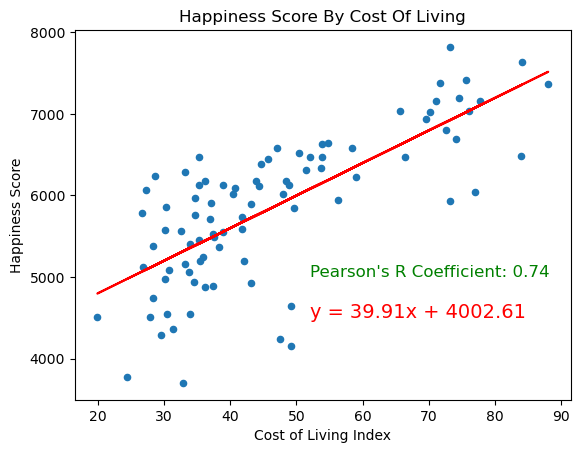

In [25]:
# Find linear regression parameters Cost of Living Index by Happiness Score
(m, y, r, p, std) = linregress(HappinessCostOfLivingCrime_df['Cost of Living Index'], HappinessCostOfLivingCrime_df['Happiness Score'])

# Calculate values for linear regression line
yregressLin = m * HappinessCostOfLivingCrime_df['Cost of Living Index'] + y

# Plot HappinessCostOfLivingCrime_df
HappinessCostOfLivingCrime_df.plot(kind='scatter', x = 'Cost of Living Index', y = 'Happiness Score')

# Create annotation text
equation = f"y = {m:.2f}x + {y:.2f}"

# Plot linear regression line
plt.plot(HappinessCostOfLivingCrime_df['Cost of Living Index'], yregressLin, color='red')
plt.annotate(equation, (52, 4500), color='red', size = 14)
plt.annotate(f"Pearson's R Coefficient: {r:.2f}", (52, 5000), color='green', size = 12)
plt.title('Happiness Score By Cost Of Living')
fig = plt.gcf()
plt.show()

In [26]:
# Create png name
figureTitle = 'HappinessCostLiving4'

# Save the figure
fig.savefig(f"Output/{figureTitle}.png")


Pearson's R Coefficient: 0.34529740930831776


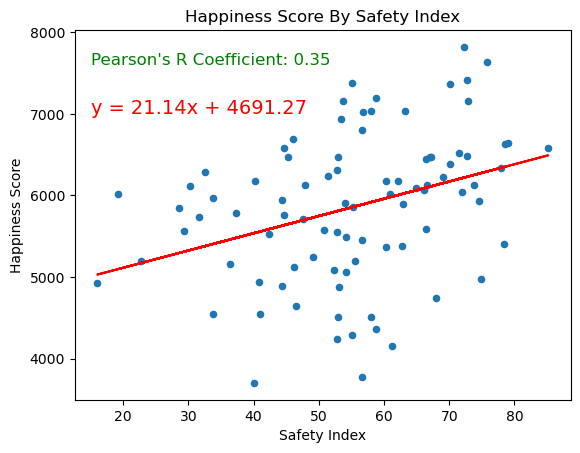

In [27]:
# Find linear regression parameters Safety Index by Happiness Score
(m, y, r, p, std) = linregress(HappinessCostOfLivingCrime_df['Safety Index'], HappinessCostOfLivingCrime_df['Happiness Score'])

# Calculate values for linear regression line
yregressLin = m * HappinessCostOfLivingCrime_df['Safety Index'] + y

# Plot HappinessCostOfLivingCrime_df
HappinessCostOfLivingCrime_df.plot(kind='scatter', x = 'Safety Index', y = 'Happiness Score')

# Create annotation text
equation = f"y = {m:.2f}x + {y:.2f}"

# Plot linear regression line
print(f"Pearson's R Coefficient: {r}")
plt.plot(HappinessCostOfLivingCrime_df['Safety Index'], yregressLin, color='red')
plt.annotate(equation, (15, 7000), color='red', size = 14)
plt.annotate(f"Pearson's R Coefficient: {r:.2f}", (15, 7600), color='green', size = 12)
plt.title('Happiness Score By Safety Index')
fig = plt.gcf()
plt.show()

In [28]:
# Create png name
figureTitle = 'HappinessSafety5'

# Save the figure
fig.savefig(f"Output/{figureTitle}.png")

Pearson's R Coefficient: 0.7428663228661702


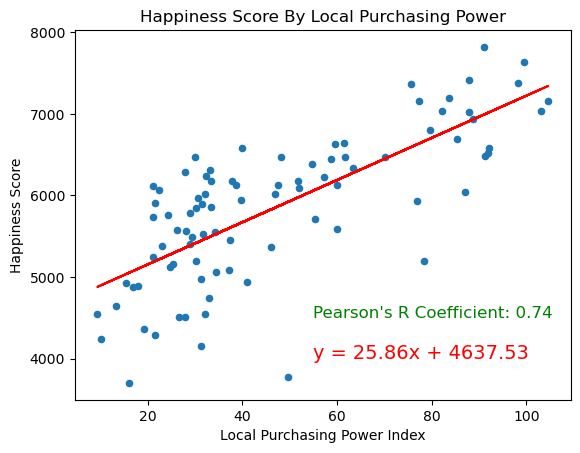

In [29]:
# Find linear regression parameters Local Purchasing Power Index by Happiness Score
(m, y, r, p, std) = linregress(HappinessCostOfLivingCrime_df['Local Purchasing Power Index'], HappinessCostOfLivingCrime_df['Happiness Score'])

# Calculate values for linear regression line
yregressLin = m * HappinessCostOfLivingCrime_df['Local Purchasing Power Index'] + y

# Plot HappinessCostOfLivingCrime_df
HappinessCostOfLivingCrime_df.plot(kind='scatter', x = 'Local Purchasing Power Index', y = 'Happiness Score')

# Create annotation text
equation = f"y = {m:.2f}x + {y:.2f}"

# Plot linear regression line
print(f"Pearson's R Coefficient: {r}")
plt.plot(HappinessCostOfLivingCrime_df['Local Purchasing Power Index'], yregressLin, color='red')
plt.annotate(equation, (55, 4000), color='red', size = 14)
plt.annotate(f"Pearson's R Coefficient: {r:.2f}", (55, 4500), color='green', size = 12)
plt.title('Happiness Score By Local Purchasing Power')
fig = plt.gcf()
plt.show()

In [30]:
# Create png name
figureTitle = 'HappinessPurchasing6'

# Save the figure
fig.savefig(f"Output/{figureTitle}.png")


In [31]:
#********************************************
# Create a dataframe loading point in order to skip steps in the event of having to restart the kernel
HappinessCostOfLivingCrime_df = pd.read_csv('./Output/CSVSavePoint/HappinessCostOfLivingCrime_df.csv')

<IPython.core.display.Javascript object>


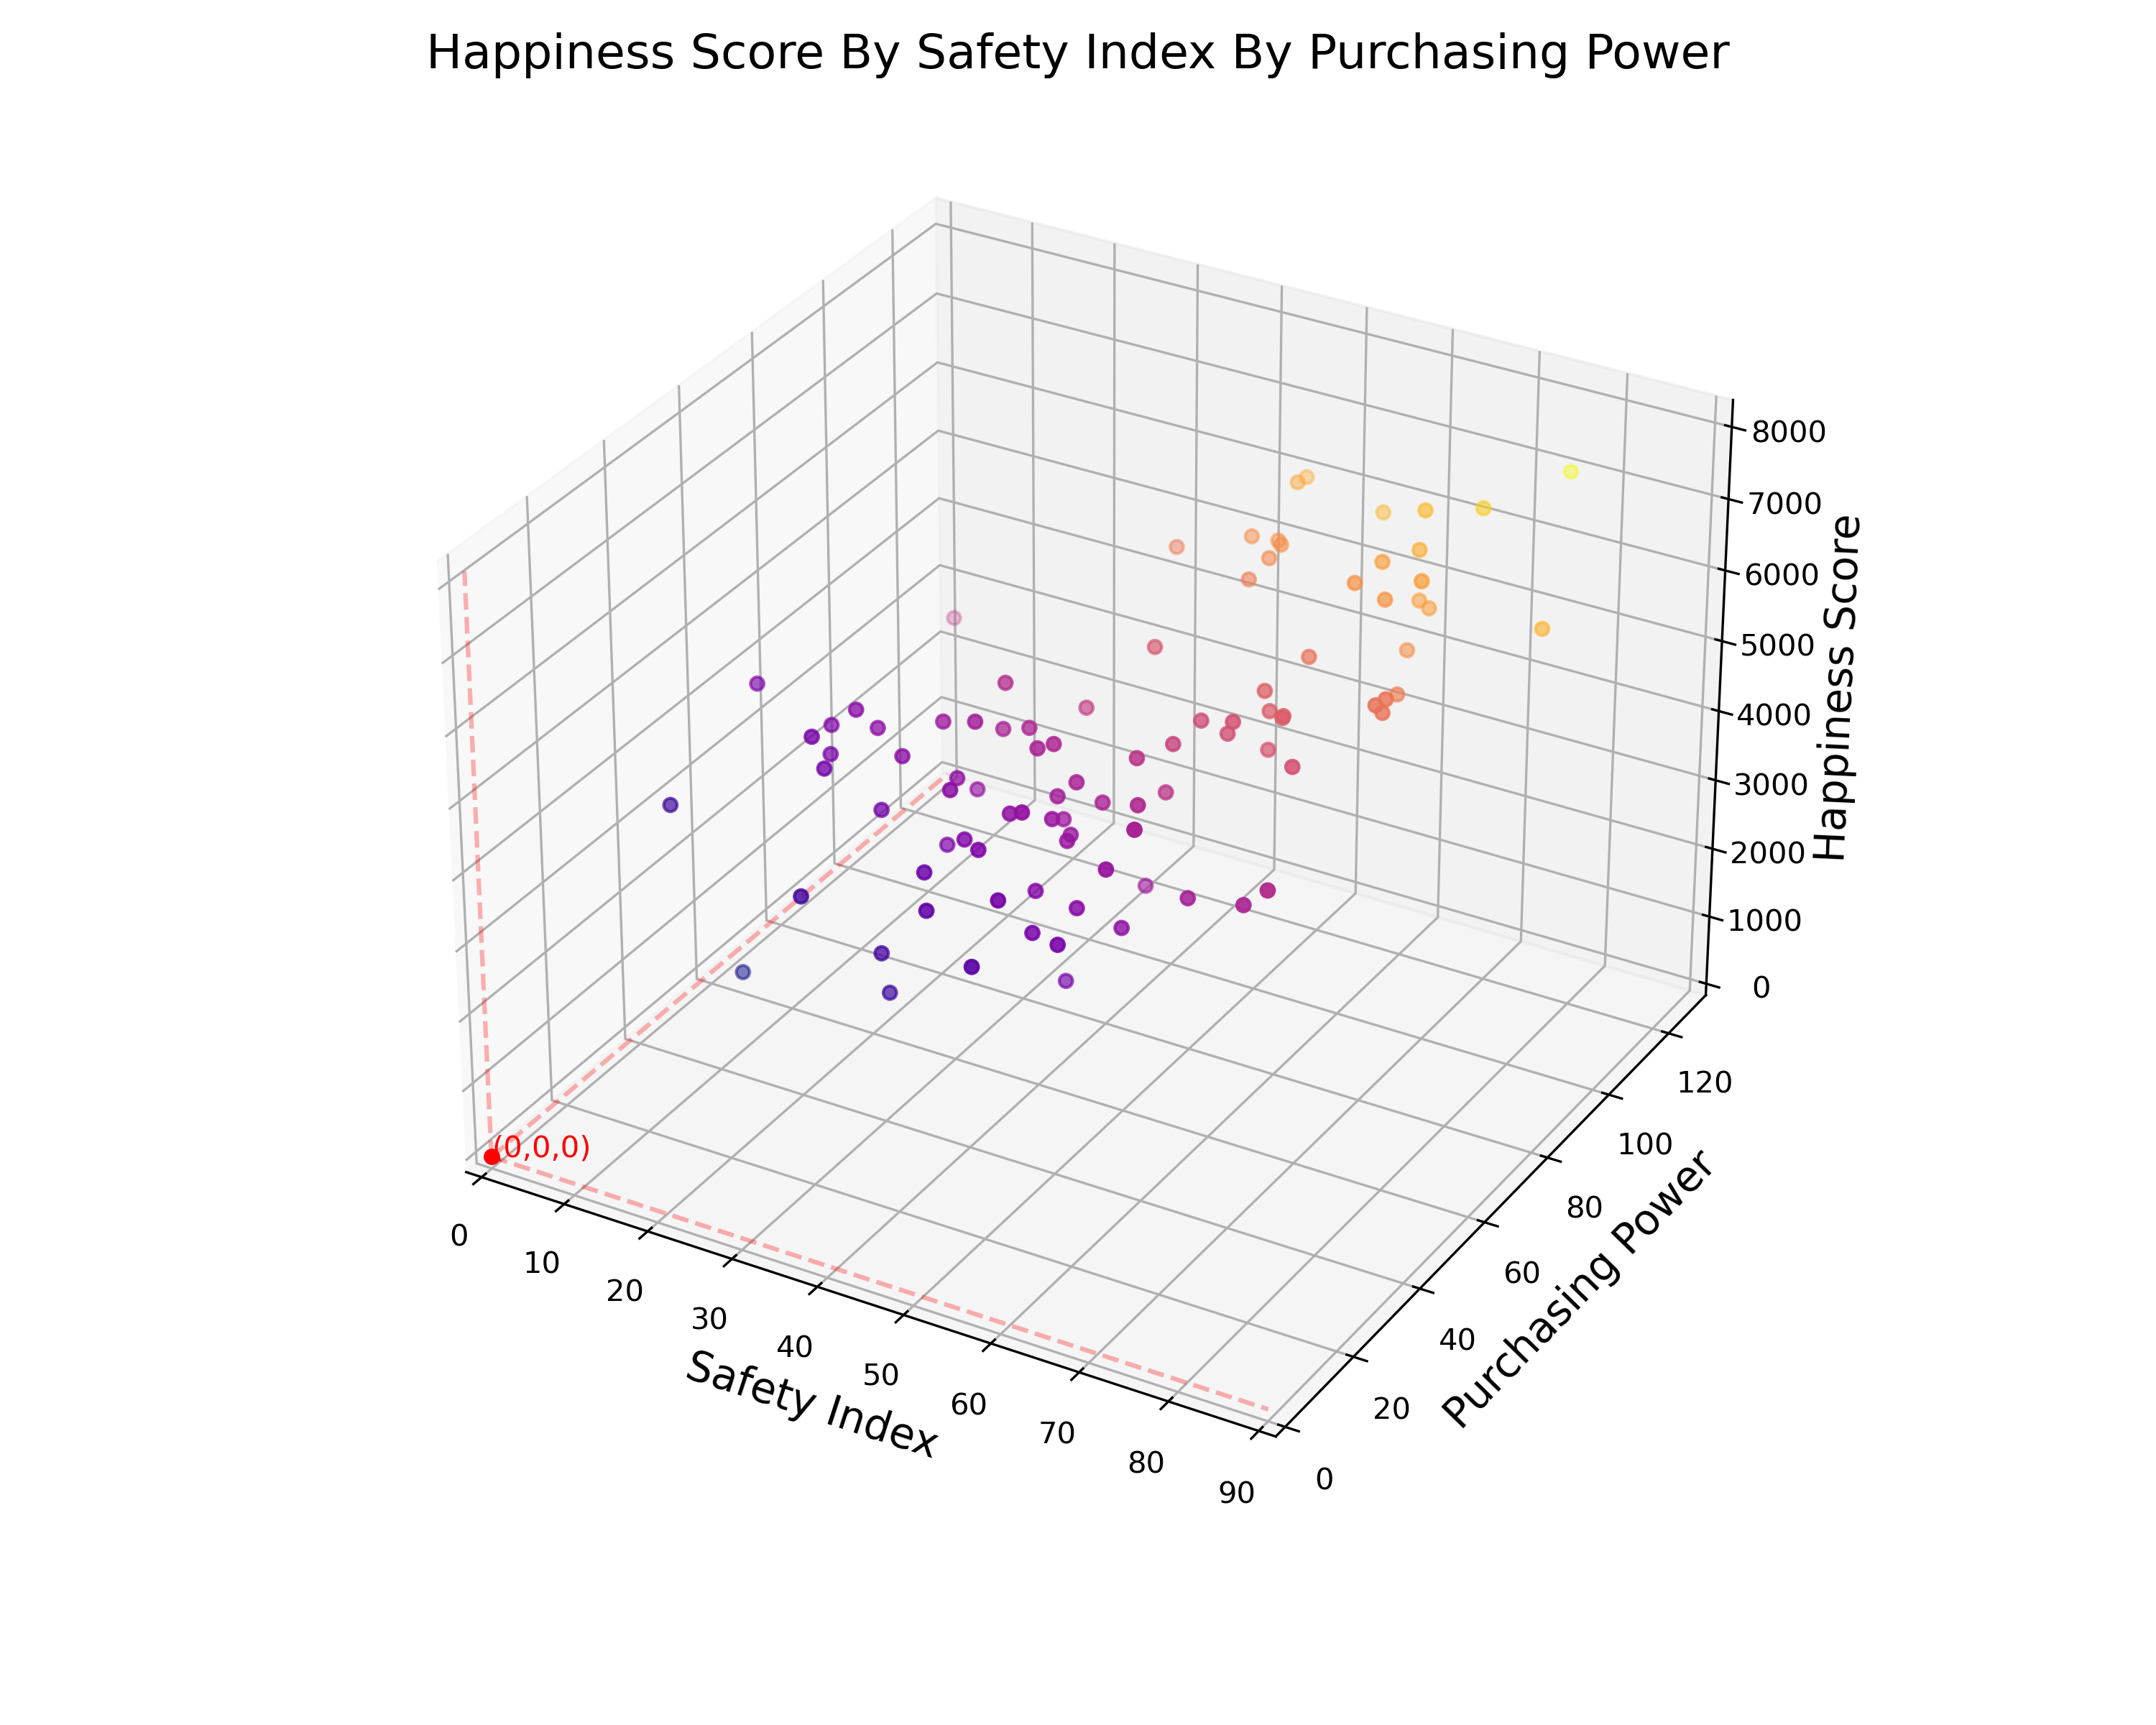

In [32]:
%matplotlib notebook

# Plot Happiness by Local Purchasing Power Index by Safety Index
fig = plt.figure(figsize=(10,8), tight_layout=True)
ax = fig.add_subplot(projection='3d')
x = HappinessCostOfLivingCrime_df['Safety Index']
xlabel = 'Safety Index'
y = HappinessCostOfLivingCrime_df['Local Purchasing Power Index']
ylabel = 'Purchasing Power'
z = HappinessCostOfLivingCrime_df['Happiness Score']
zlabel = 'Happiness Score'
colors = np.random.rand(367)
# bin = [3000, 3500, 4000, 4500, 5000 ]
topHap = HappinessCostOfLivingCrime_df['Happiness Score'].sort_values(ascending=False).head(1).values[0]
topPurch = HappinessCostOfLivingCrime_df['Local Purchasing Power Index'].sort_values(ascending=False).head(1).values[0]
topSafety = HappinessCostOfLivingCrime_df['Safety Index'].sort_values(ascending=False).head(1).values[0]
red = HappinessCostOfLivingCrime_df['Happiness Score']/topHap
green = HappinessCostOfLivingCrime_df['Local Purchasing Power Index']/topSafety
blue = HappinessCostOfLivingCrime_df['Safety Index']/topPurch 
triple = (red+ green+blue)/3


xmin = 0
xmax = 90
ymin = 0
ymax = 130
zmin = 0
zmax = 8200

ax.scatter(x, y, z, cmap='plasma', c=triple)# xlabel=xlabel, ylabel=ylabel)
ax.set_xlabel(xlabel, fontsize=14)
ax.set_ylabel(ylabel, fontsize=14)
ax.set_zlabel(zlabel, fontsize=14)
plt.subplots_adjust(right=0.5, bottom=0.5)
plt.title('Happiness Score By Safety Index By Purchasing Power', fontsize=16)

# Show origin
ax.scatter3D(0,0,0, color = 'red')
ax.text(0.01,0.01,0, '(0,0,0)', color = 'red')
xmin = 0
xmax = 90
ymin = 0
ymax = 130
zmin = 0
zmax = 8200
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_zlim(zmin,zmax)
plt.plot([xmin, xmax],(0,0),(0,0), color='red', linestyle='dashed', alpha=0.3)
plt.plot((0,0),[ymin, ymax],(0,0), color='red', linestyle='dashed', alpha=0.3)
plt.plot((0,0),(0,0),[zmin, zmax], color='red', linestyle='dashed', alpha=0.3)

# Hover cursor
country = HappinessCostOfLivingCrime_df['Country']
safety = x
happiness = y
purchasingPower = z
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set(text = 
    f"{country[sel.target.index]}:\nSafety: {safety[sel.target.index]:.0f}\nPurchasing Power: {purchasingPower[sel.target.index]:.0f}\nHappiness: {happiness[sel.target.index]:.0f}"))

fig1 = plt.gcf()
plt.show()

In [33]:
# Create png name
figureTitle = 'HappinessPurchSafety3D7'

# Save the figure
fig1.savefig(f"Output/{figureTitle}.png")

In [34]:
# Find minimum values for Happiness Score, Local Purchasing Power Index, and Safety Index  
bottomHap = HappinessCostOfLivingCrime_df['Happiness Score'].min()
bottomPurch = HappinessCostOfLivingCrime_df['Local Purchasing Power Index'].min()
bottompSafety = HappinessCostOfLivingCrime_df['Safety Index'].min()

# Find maximum values for Happiness Score, Local Purchasing Power Index, and Safety Index  
topHap = HappinessCostOfLivingCrime_df['Happiness Score'].max()
topPurch = HappinessCostOfLivingCrime_df['Local Purchasing Power Index'].max()
topSafety = HappinessCostOfLivingCrime_df['Safety Index'].max()

# Create columns for normalized values for Happiness Score, Local Purchasing Power Index, and Safety Index  
HappinessCostOfLivingCrime_df['Normalized Happiness'] = (HappinessCostOfLivingCrime_df['Happiness Score'] - bottomHap) / (topHap - bottomHap)
HappinessCostOfLivingCrime_df['Normalized Local Purchasing Power'] = (HappinessCostOfLivingCrime_df['Local Purchasing Power Index'] - bottomPurch) / (topPurch - bottomPurch)
HappinessCostOfLivingCrime_df['Normalized Safety'] = (HappinessCostOfLivingCrime_df['Safety Index'] - bottompSafety) / (topSafety - bottompSafety)
HappinessCostOfLivingCrime_df.head()


Unnamed: 0.1  Unnamed: 0      Country  Happiness Score  \
0             0           0      Finland           7821.0   
1             1           1      Denmark           7636.0   
2             2           2      Iceland           7557.0   
3             3           3  Switzerland           7512.0   
4             4           4  Netherlands           7415.0   

   Local Purchasing Power Index  Cost of Living Index     Capital   Latitude  \
0                         91.02                 73.20    Helsinki  60.166667   
1                         99.45                 84.12  Copenhagen  55.666667   
2                         77.06                 94.86   Reykjavik  64.150000   
3                        118.44                123.35        Bern  46.916667   
4                         87.99                 75.66   Amsterdam  52.350000   

   Longitude        Rank  Crime Index  Safety Index  Normalized Happiness  \
0  24.933333  380.333333    27.763333     72.236667              1.000000   
1  12.583333  411.000000    24.270000     75.730000              0.965848   
2 -21.950000  421.000000    23.020000     76.980000              0.951265   
3   7.466667  427.833333    21.156667     78.843333              0.942957   
4   4.916667  385.500000    27.235000     72.765000              0.925051   

   Normalized Local Purchasing Power  Normalized Safety  
0                           0.748671           0.812908  
1                           0.825940           0.863423  
2                           0.620715           0.881498  
3                           1.000000           0.908442  
4                           0.720898           0.820548

<IPython.core.display.Javascript object>


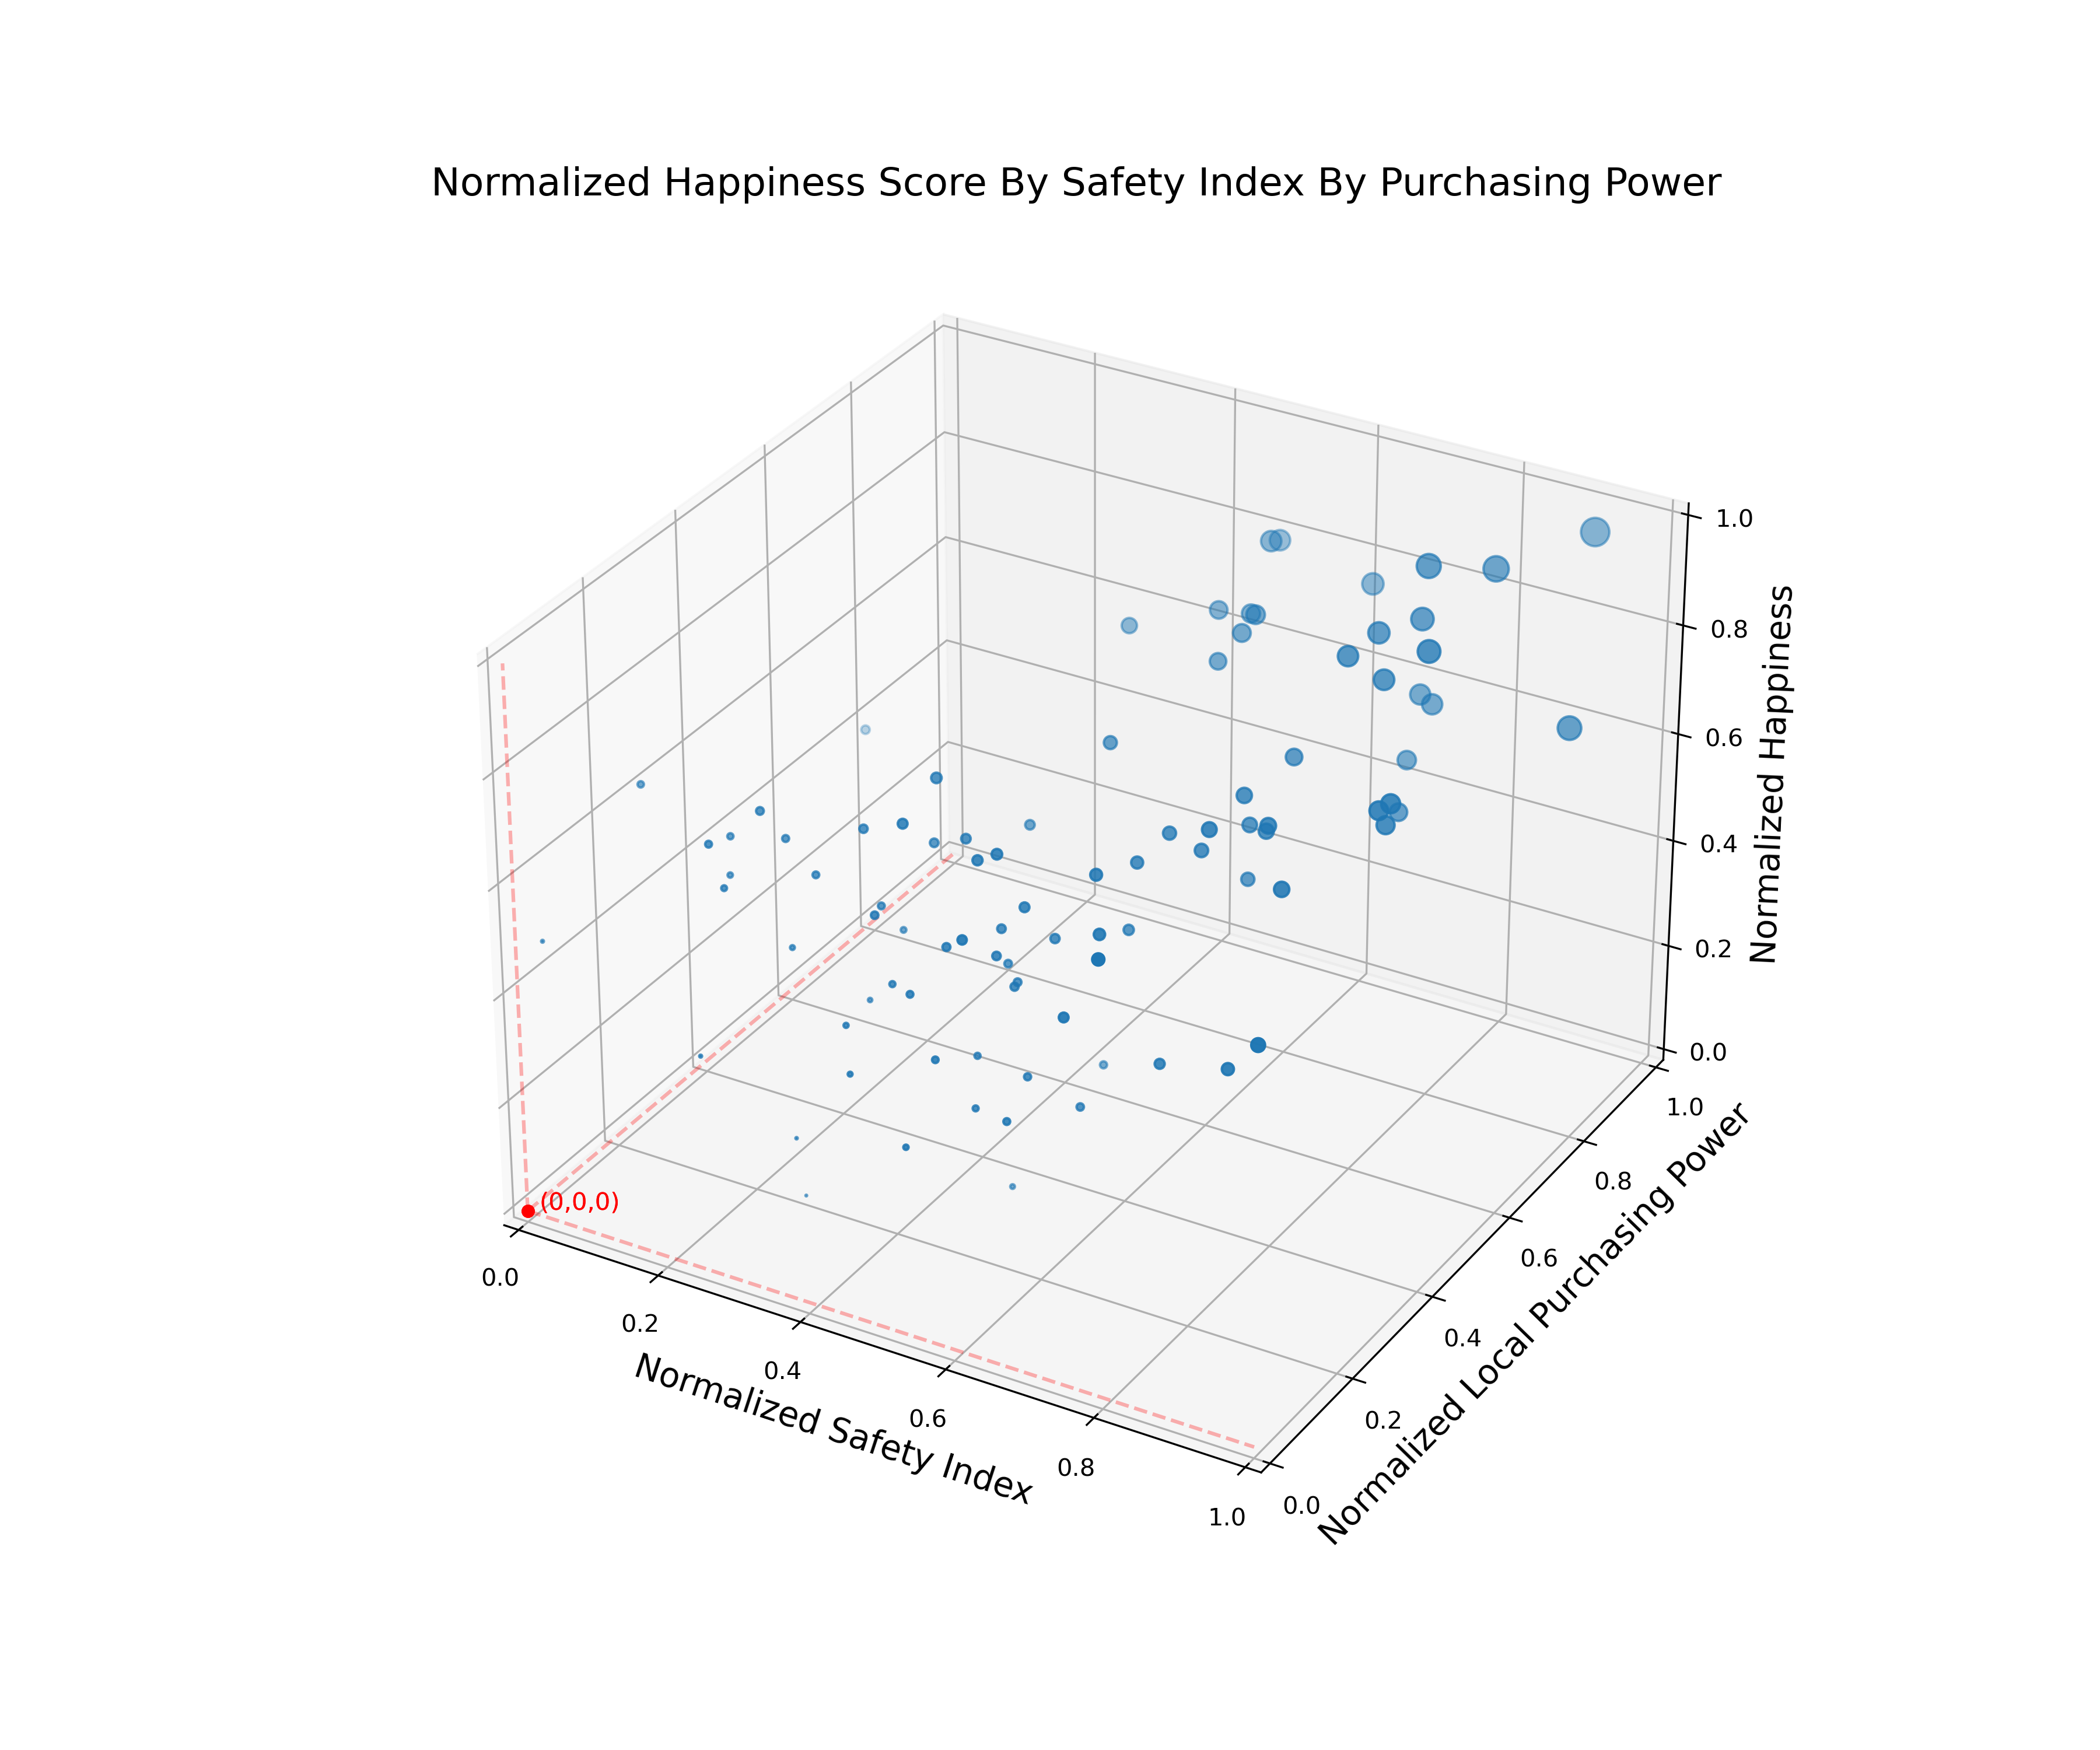

C:\Users\snbad\anaconda3\envs\dev\lib\site-packages\mplcursors\_pick_info.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  paths = scatter.__wrapped__(*args, **kwargs)


In [35]:
%matplotlib notebook

# Create weights for combining normalized Happiness Score, Local Purchasing Power Index, and Safety Index into a single value
weightHap = 1
weightPurch = 1
weightSafety = 1

# Create a new column by combining the three metrics (Normalized Happiness, Safety, Purchasing Power) into one metric
HappinessCostOfLivingCrime_df['Equally Weighted Safety, Purchasing, and Happiness'] = np.sqrt((HappinessCostOfLivingCrime_df['Normalized Safety'] * weightSafety)**2 + 
                            (HappinessCostOfLivingCrime_df['Normalized Local Purchasing Power'] * weightPurch)**2 + 
                            (HappinessCostOfLivingCrime_df['Normalized Happiness'] * weightHap)**2)

# Plot normalized-combined metric 'Equally Weighted Safety, Purchasing, and Happiness'
plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')

# print(HappinessCostOfLivingCrime_df)
# Find min
minimumEquallyWeighted = HappinessCostOfLivingCrime_df['Equally Weighted Safety, Purchasing, and Happiness'].min()

visualFactor = 40
x = HappinessCostOfLivingCrime_df['Normalized Safety']
y = HappinessCostOfLivingCrime_df['Normalized Local Purchasing Power']
z = HappinessCostOfLivingCrime_df['Normalized Happiness']
size = HappinessCostOfLivingCrime_df['Equally Weighted Safety, Purchasing, and Happiness']

# Size of datapoint will increase with distance from origin (0,0,0)
fg = ax.scatter3D(x, y, z, 
                  s = visualFactor * (size - minimumEquallyWeighted)**3,
                  cmap='plasma'
                  )

# Labels
ax.set_title('Normalized Happiness Score By Safety Index By Purchasing Power', fontsize=16)
ax.scatter3D(0,0,0, color = 'red')
ax.text(0.01,0.01,0, '(0,0,0)', color = 'red')
ax.set_xlabel('Normalized Safety Index', fontsize=14)
ax.set_ylabel('Normalized Local Purchasing Power', fontsize=14)
ax.set_zlabel('Normalized Happiness', fontsize=14)


# Show origin
ax.scatter3D(0,0,0, color = 'red')
ax.text(0.01,0.01,0, '(0,0,0)', color = 'red')
xmin = 0
xmax = 1
ymin = 0
ymax = 1
zmin = 0
zmax = 1
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_zlim(zmin,zmax)
plt.plot([xmin, xmax],(0,0),(0,0), color='red', linestyle='dashed', alpha=0.3)
plt.plot((0,0),[ymin, ymax],(0,0), color='red', linestyle='dashed', alpha=0.3)
plt.plot((0,0),(0,0),[zmin, zmax], color='red', linestyle='dashed', alpha=0.3)

# Hover cursor
labels = HappinessCostOfLivingCrime_df['Country']
country = HappinessCostOfLivingCrime_df['Country']
safety = x
happiness = y
purchasingPower = z
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set(text = 
    f"{country[sel.target.index]}:\nSafety: {safety[sel.target.index]:.2f}\nPurchasing Power: {purchasingPower[sel.target.index]:.2f}\nHappiness: {happiness[sel.target.index]:.2f}\nCombined (Distance to Origin): {size[sel.target.index]:.2f}"))

fig1 = plt.gcf()
plt.show()

In [36]:
# Create png name
figureTitle = 'NormalizedHappinessPurchSafety3D8'

# Save the figure
fig1.savefig(f"Output/{figureTitle}.png")

In [37]:
# Save dataFrame to csv
HappinessCostOfLivingCrime_df.to_csv('./Output/CSVSavePoint/HappinessCostOfLivingCrime_dfNorm.csv')

In [38]:
#********************************************
# Create a dataframe loading point in order to skip steps in the event of having to restart the kernel
HappinessCostOfLivingCrime_df = pd.read_csv('./Output/CSVSavePoint/HappinessCostOfLivingCrime_dfNorm.csv')

In [39]:
# Calculate and create columns for Z-scores of Happiness Score, Local Purchasing Power Index, and Safety Index
from scipy.stats import zscore
HappinessCostOfLivingCrime_df['Z-Score Happiness Score'] = zscore(HappinessCostOfLivingCrime_df['Happiness Score'])
HappinessCostOfLivingCrime_df['Z-Score Safety Index'] = zscore(HappinessCostOfLivingCrime_df['Safety Index'])
HappinessCostOfLivingCrime_df['Z-Score Local Purchasing Power'] = zscore(HappinessCostOfLivingCrime_df['Local Purchasing Power Index'])
HappinessCostOfLivingCrime_df.head()

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0      Country  Happiness Score  \
0             0             0           0      Finland           7821.0   
1             1             1           1      Denmark           7636.0   
2             2             2           2      Iceland           7557.0   
3             3             3           3  Switzerland           7512.0   
4             4             4           4  Netherlands           7415.0   

   Local Purchasing Power Index  Cost of Living Index     Capital   Latitude  \
0                         91.02                 73.20    Helsinki  60.166667   
1                         99.45                 84.12  Copenhagen  55.666667   
2                         77.06                 94.86   Reykjavik  64.150000   
3                        118.44                123.35        Bern  46.916667   
4                         87.99                 75.66   Amsterdam  52.350000   

   Longitude        Rank  Crime Index  Safety Index  Normalized Happiness  \
0  24.933333  380.333333    27.763333     72.236667              1.000000   
1  12.583333  411.000000    24.270000     75.730000              0.965848   
2 -21.950000  421.000000    23.020000     76.980000              0.951265   
3   7.466667  427.833333    21.156667     78.843333              0.942957   
4   4.916667  385.500000    27.235000     72.765000              0.925051   

   Normalized Local Purchasing Power  Normalized Safety  \
0                           0.748671           0.812908   
1                           0.825940           0.863423   
2                           0.620715           0.881498   
3                           1.000000           0.908442   
4                           0.720898           0.820548   

   Equally Weighted Safety, Purchasing, and Happiness  \
0                                           1.490412    
1                                           1.536404    
2                                           1.437787    
3                                           1.647555    
4                                           1.431332    

   Z-Score Happiness Score  Z-Score Safety Index  \
0                 1.878166              1.117736   
1                 1.705324              1.347331   
2                 1.631516              1.429486   
3                 1.589473              1.551951   
4                 1.498848              1.152460   

   Z-Score Local Purchasing Power  
0                        1.605072  
1                        1.919171  
2                        1.084926  
3                        2.626732  
4                        1.492175

<IPython.core.display.Javascript object>


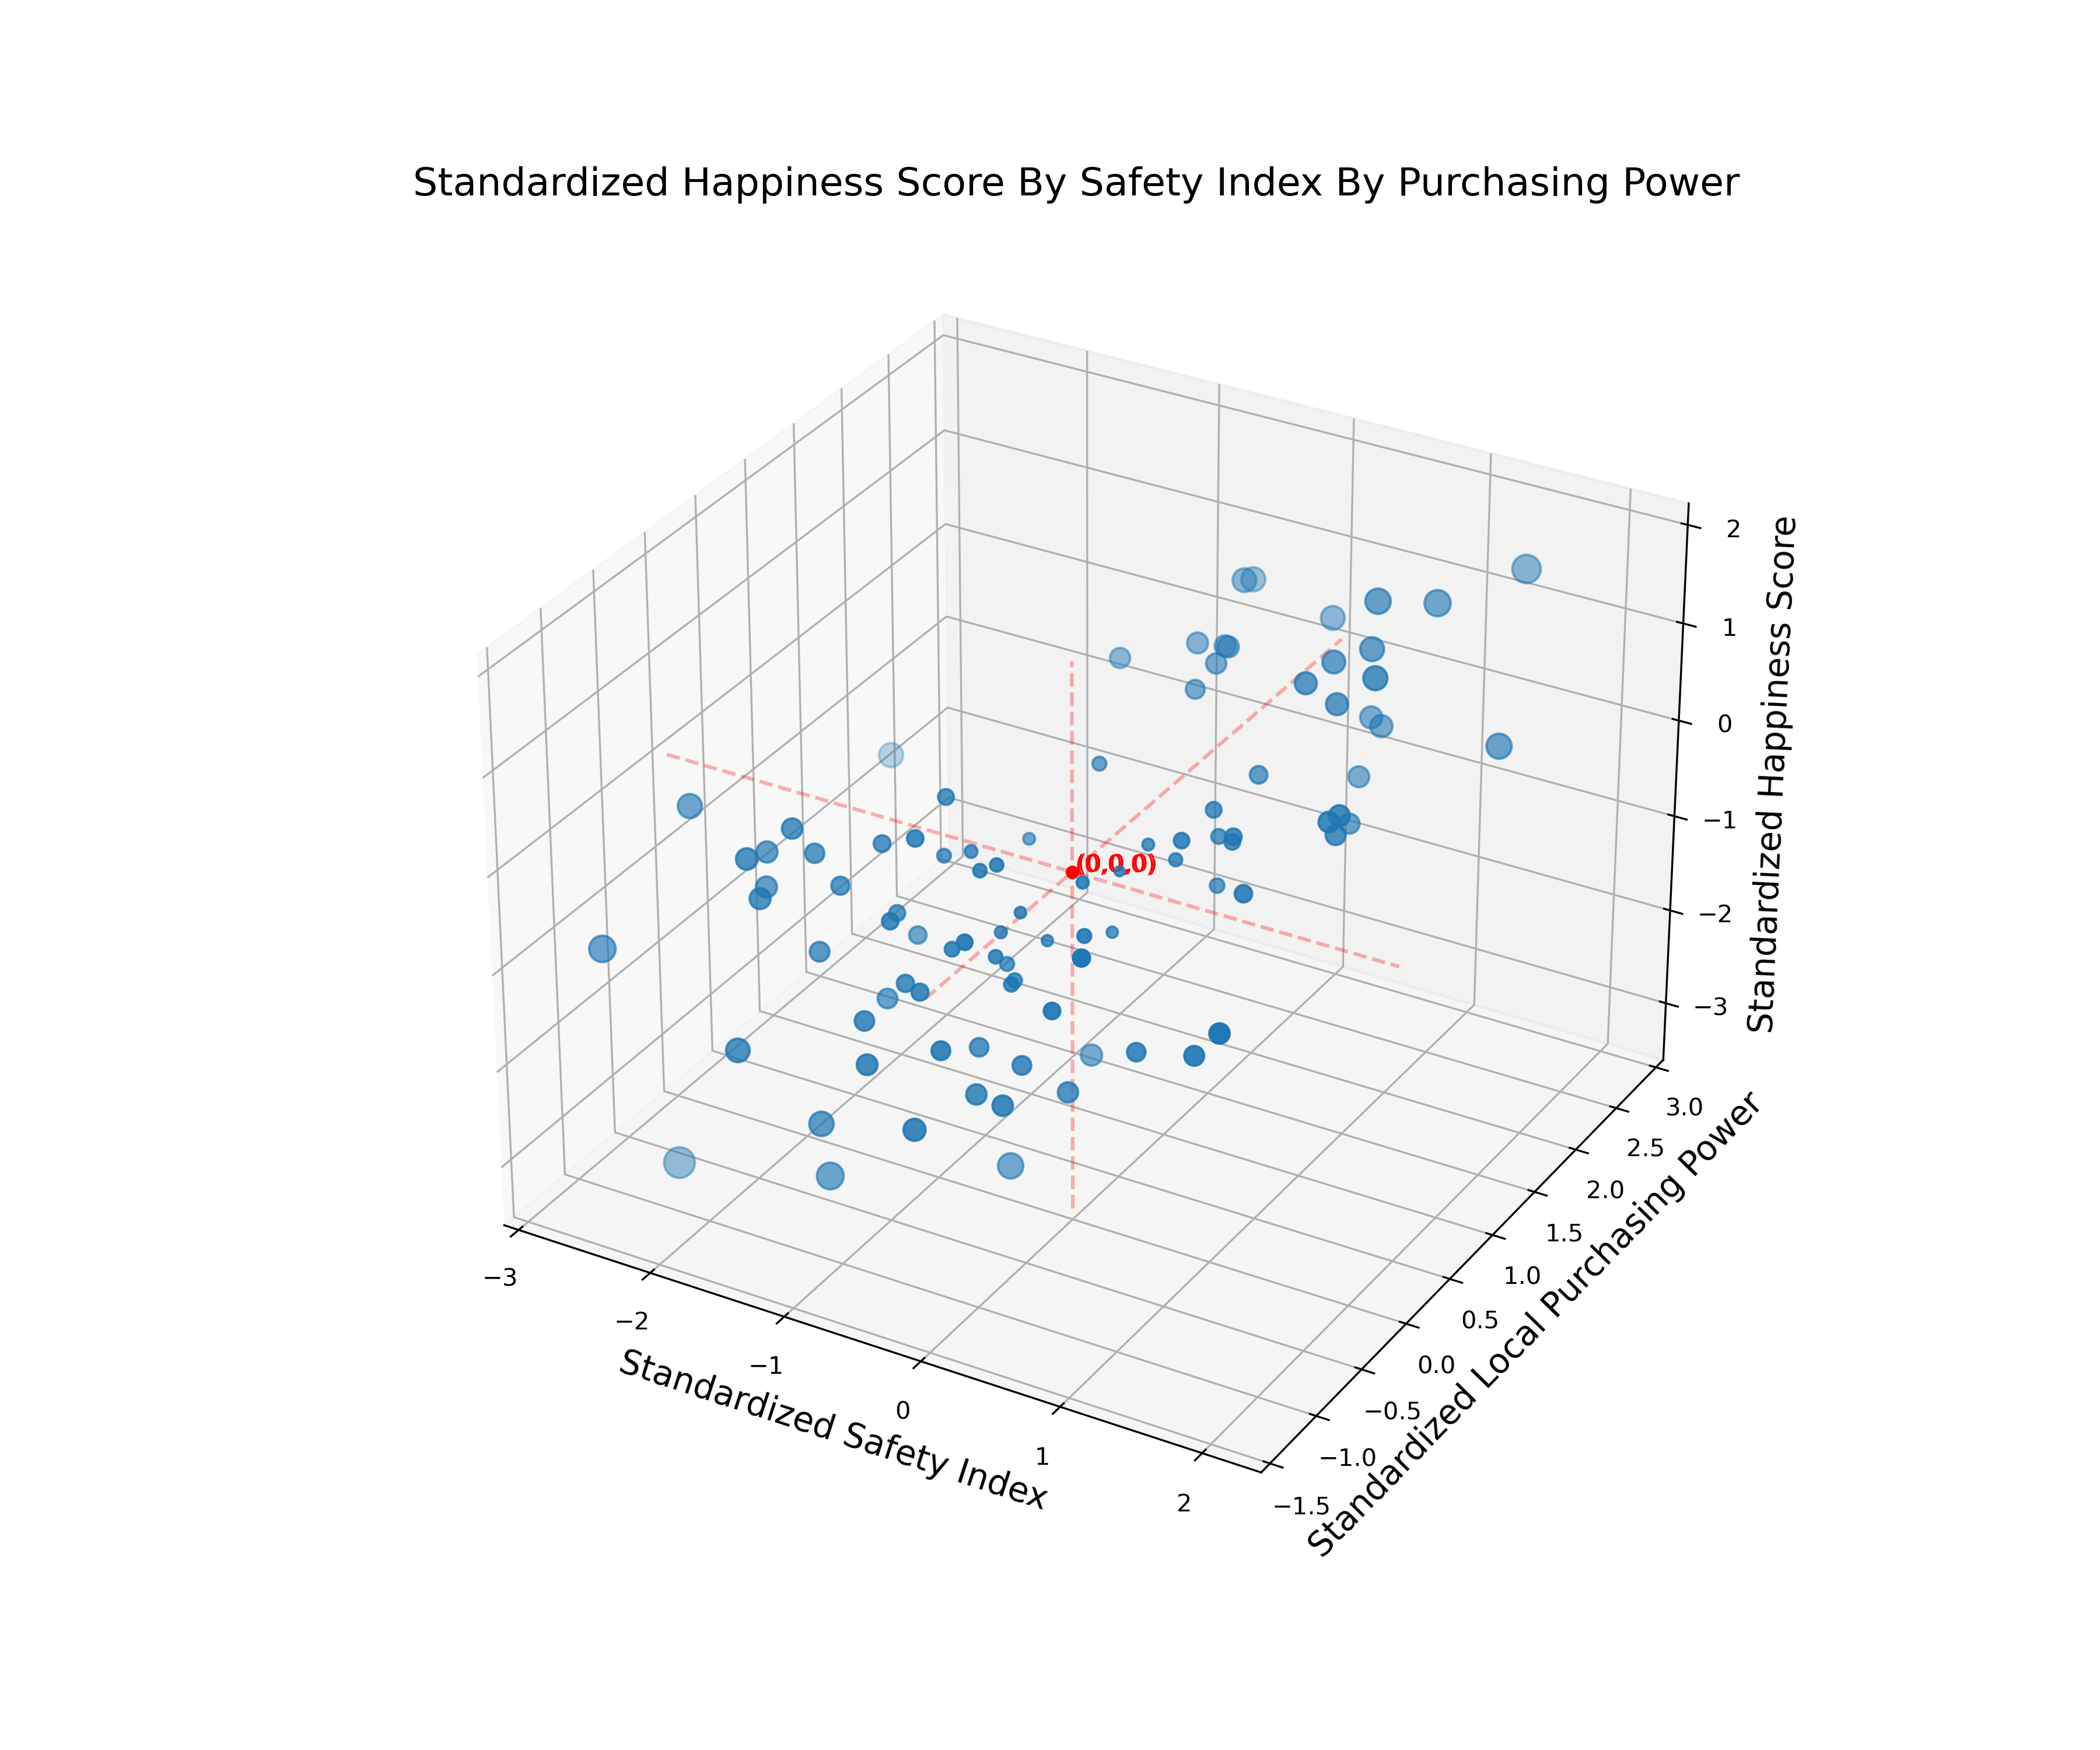

C:\Users\snbad\anaconda3\envs\dev\lib\site-packages\mplcursors\_pick_info.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  paths = scatter.__wrapped__(*args, **kwargs)


In [40]:
%matplotlib notebook

# Create weights for combining Z-score Happiness Score, Z-score Local Purchasing Power Index, and Z-score Safety Index into a single value
weightHap = 1
weightPurch = 1
weightSafety = 1

# Create a new column by combining the three metrics (Normalized Happiness, Safety, Purchasing Power) into one metric
HappinessCostOfLivingCrime_df['Equally Weighted Z-Score Safety, Purchasing, and Happiness'] = np.sqrt((HappinessCostOfLivingCrime_df['Z-Score Safety Index'] * weightSafety)**2 + 
                            (HappinessCostOfLivingCrime_df['Z-Score Local Purchasing Power'] * weightPurch)**2 + 
                            (HappinessCostOfLivingCrime_df['Z-Score Happiness Score'] * weightHap)**2)

# Plot normalized-combined metric 'Equally Weighted Safety, Purchasing, and Happiness'
plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')

# print(HappinessCostOfLivingCrime_df)
# Find min
minimumEquallyWeightedZScore = HappinessCostOfLivingCrime_df['Equally Weighted Z-Score Safety, Purchasing, and Happiness'].min()

visualFactor = 40
x = HappinessCostOfLivingCrime_df['Z-Score Safety Index']
y = HappinessCostOfLivingCrime_df['Z-Score Local Purchasing Power']
z = HappinessCostOfLivingCrime_df['Z-Score Happiness Score']
size = HappinessCostOfLivingCrime_df['Equally Weighted Z-Score Safety, Purchasing, and Happiness']

# Size of datapoint will increase with distance from origin (0,0,0)
fg = ax.scatter3D(x, y, z, s = size * visualFactor, cmap='plasma')

# Labels
ax.set_title('Standardized Happiness Score By Safety Index By Purchasing Power', fontsize=16)
ax.set_xlabel('Standardized Safety Index', fontsize=14)
ax.set_ylabel('Standardized Local Purchasing Power', fontsize=14)
ax.set_zlabel('Standardized Happiness Score', fontsize=14)
ax.scatter3D(0,0,0, color = 'red')
ax.text(0.02,0.02,0, '(0,0,0)', color = 'red')


# Show origin
ax.scatter3D(0,0,0, color = 'red')
ax.text(0.01,0.01,0, '(0,0,0)', color = 'red')
xmin = -3
xmax = 2.3
ymin = -1.5
ymax = 3
zmin = -3.5
zmax = 2.1
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_zlim(zmin,zmax)
plt.plot([xmin, xmax],(0,0),(0,0), color='red', linestyle='dashed', alpha=0.3)
plt.plot((0,0),[ymin, ymax],(0,0), color='red', linestyle='dashed', alpha=0.3)
plt.plot((0,0),(0,0),[zmin, zmax], color='red', linestyle='dashed', alpha=0.3)

# Hover cursor
labels = HappinessCostOfLivingCrime_df['Country']
country = HappinessCostOfLivingCrime_df['Country']
safety = x
happiness = y
purchasingPower = z
combined = size
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set(text = 
    f"{country[sel.target.index]}:\nSafety: {safety[sel.target.index]:.2f}\nPurchasing Power: {purchasingPower[sel.target.index]:.2f}\nHappiness: {happiness[sel.target.index]:.2f}\nCombined (Distance from Origin): {combined[sel.target.index]:.2f}"))

fig1 = plt.gcf()
plt.show()

In [41]:
# Create png name
figureTitle = 'StandardizedHappinessPurchSafety3D8b'

# Save the figure
fig1.savefig(f"Output/{figureTitle}.png")

In [42]:
# Save dataFrame to csv
HappinessCostOfLivingCrime_df.to_csv('./Output/CSVSavePoint/HappinessCostOfLivingCrime_dfZScore.csv')

In [43]:
#********************************************
# Create a dataframe loading point in order to skip steps in the event of having to restart the kernel
HappinessCostOfLivingCrime_df = pd.read_csv('./Output/CSVSavePoint/HappinessCostOfLivingCrime_dfZScore.csv')

In [44]:
HappinessCostOfLivingCrime_df.sort_values('Z-Score Local Purchasing Power', ascending=False).head(30)

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
3              3             3             3           3   
10            10            10            10          10   
12            12            12            12          12   
1              1             1             1           1   
5              5             5             5           5   
20            20            20            20          20   
21            21            21            21          21   
22            22            22            22          22   
0              0             0             0           0   
14            14            14            14          14   
4              4             4             4           4   
13            13            13            13          13   
43            43            43            43          46   
16            16            16            16          16   
8              8             8             8           8   
6              6             6             6           6   
11            11            11            11          11   
15            15            15            15          15   
69            69            69            69          73   
9              9             9             9           9   
2              2             2             2           2   
48            48            48            48          51   
7              7             7             7           7   
24            24            24            24          24   
29            29            29            29          30   
26            26            26            26          26   
17            17            17            17          17   
57            57            57            57          61   
39            39            39            39          41   
18            18            18            18          18   

                 Country  Happiness Score  Local Purchasing Power Index  \
3            Switzerland           7512.0                        118.44   
10             Australia           7162.0                        104.63   
12               Germany           7034.0                        103.08   
1                Denmark           7636.0                         99.45   
5                 Sweden           7384.0                         98.14   
20  United Arab Emirates           6576.0                         92.17   
21          Saudi Arabia           6523.0                         91.85   
22             Singapore           6480.0                         91.34   
0                Finland           7821.0                         91.02   
14        United Kingdom           6943.0                         88.78   
4            Netherlands           7415.0                         87.99   
13                Canada           7025.0                         87.98   
43                 Japan           6039.0                         87.11   
16                France           6687.0                         85.41   
8            New Zealand           7200.0                         83.63   
6                 Norway           7365.0                         83.11   
11               Ireland           7041.0                         82.27   
15               Belgium           6805.0                         79.72   
69          South Africa           5194.0                         78.36   
9                Austria           7163.0                         77.25   
2                Iceland           7557.0                         77.06   
48           South Korea           5935.0                         76.85   
7                 Israel           7364.0                         75.58   
24                 Spain           6476.0                         70.04   
29               Estonia           6341.0                         63.46   
26                 Italy           6467.0                         61.74   
17               Bahrain           6647.0                         61.41   
57                 China           5585.0  

In [45]:
HappinessCostOfLivingCrime_df.head()

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0      Country  \
0             0             0             0           0      Finland   
1             1             1             1           1      Denmark   
2             2             2             2           2      Iceland   
3             3             3             3           3  Switzerland   
4             4             4             4           4  Netherlands   

   Happiness Score  Local Purchasing Power Index  Cost of Living Index  \
0           7821.0                         91.02                 73.20   
1           7636.0                         99.45                 84.12   
2           7557.0                         77.06                 94.86   
3           7512.0                        118.44                123.35   
4           7415.0                         87.99                 75.66   

      Capital   Latitude  ...  Crime Index  Safety Index  \
0    Helsinki  60.166667  ...    27.763333     72.236667   
1  Copenhagen  55.666667  ...    24.270000     75.730000   
2   Reykjavik  64.150000  ...    23.020000     76.980000   
3        Bern  46.916667  ...    21.156667     78.843333   
4   Amsterdam  52.350000  ...    27.235000     72.765000   

   Normalized Happiness  Normalized Local Purchasing Power  Normalized Safety  \
0              1.000000                           0.748671           0.812908   
1              0.965848                           0.825940           0.863423   
2              0.951265                           0.620715           0.881498   
3              0.942957                           1.000000           0.908442   
4              0.925051                           0.720898           0.820548   

   Equally Weighted Safety, Purchasing, and Happiness  \
0                                           1.490412    
1                                           1.536404    
2                                           1.437787    
3                                           1.647555    
4                                           1.431332    

   Z-Score Happiness Score  Z-Score Safety Index  \
0                 1.878166              1.117736   
1                 1.705324              1.347331   
2                 1.631516              1.429486   
3                 1.589473              1.551951   
4                 1.498848              1.152460   

   Z-Score Local Purchasing Power  \
0                        1.605072   
1                        1.919171   
2                        1.084926   
3                        2.626732   
4                        1.492175   

   Equally Weighted Z-Score Safety, Purchasing, and Happiness  
0                                           2.711660           
1                                           2.899422           
2                                           2.425353           
3                                           3.440160           
4                                           2.408588           

[5 rows x 22 columns]

In [46]:
top10EquallyWeighted = HappinessCostOfLivingCrime_df.sort_values('Equally Weighted Safety, Purchasing, and Happiness', ascending=False).head(10)
top10EquallyWeighted

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
3              3             3             3           3   
1              1             1             1           1   
0              0             0             0           0   
20            20            20            20          20   
2              2             2             2           2   
4              4             4             4           4   
12            12            12            12          12   
6              6             6             6           6   
9              9             9             9           9   
10            10            10            10          10   

                 Country  Happiness Score  Local Purchasing Power Index  \
3            Switzerland           7512.0                        118.44   
1                Denmark           7636.0                         99.45   
0                Finland           7821.0                         91.02   
20  United Arab Emirates           6576.0                         92.17   
2                Iceland           7557.0                         77.06   
4            Netherlands           7415.0                         87.99   
12               Germany           7034.0                        103.08   
6                 Norway           7365.0                         83.11   
9                Austria           7163.0                         77.25   
10             Australia           7162.0                        104.63   

    Cost of Living Index     Capital   Latitude  ...  Crime Index  \
3                 123.35        Bern  46.916667  ...    21.156667   
1                  84.12  Copenhagen  55.666667  ...    24.270000   
0                  73.20    Helsinki  60.166667  ...    27.763333   
20                 58.33   Abu Dhabi  24.466667  ...    14.825000   
2                  94.86   Reykjavik  64.150000  ...    23.020000   
4                  75.66   Amsterdam  52.350000  ...    27.235000   
12                 65.58      Berlin  52.516667  ...    36.858000   
6                 100.90        Oslo  59.916667  ...    29.610000   
9                  71.04      Vienna  48.200000  ...    27.115000   
10                 77.75    Canberra -35.266667  ...    46.273750   

    Safety Index  Normalized Happiness  Normalized Local Purchasing Power  \
3      78.843333              0.942957                           1.000000   
1      75.730000              0.965848                           0.825940   
0      72.236667              1.000000                           0.748671   
20     85.175000              0.770168                           0.759212   
2      76.980000              0.951265                           0.620715   
4      72.765000              0.925051                           0.720898   
12     63.142000              0.854717                           0.859212   
6      70.390000              0.915821                           0.676169   
9      72.885000              0.878531                           0.622456   
10     53.726250              0.878346                           0.873419   

    Normalized Safety  Equally Weighted Safety, Purchasing, and Happiness  \
3            0.908442                                           1.647555    
1            0.863423                                           1.536404    
0            0.812908                                           1.490412    
20           1.000000                                           1.472943    
2            0.881498                                           1.437787    
4            0.820548                                           1.431332    
12           0.681397                                           1.390355    
6            0.786205                                           1.383492    
9            0.822283                                           1.354776    
10           0.545243                                           1.353382    

    Z-Score Happiness Score  Z-Score Safety Index  \
3       

<IPython.core.display.Javascript object>


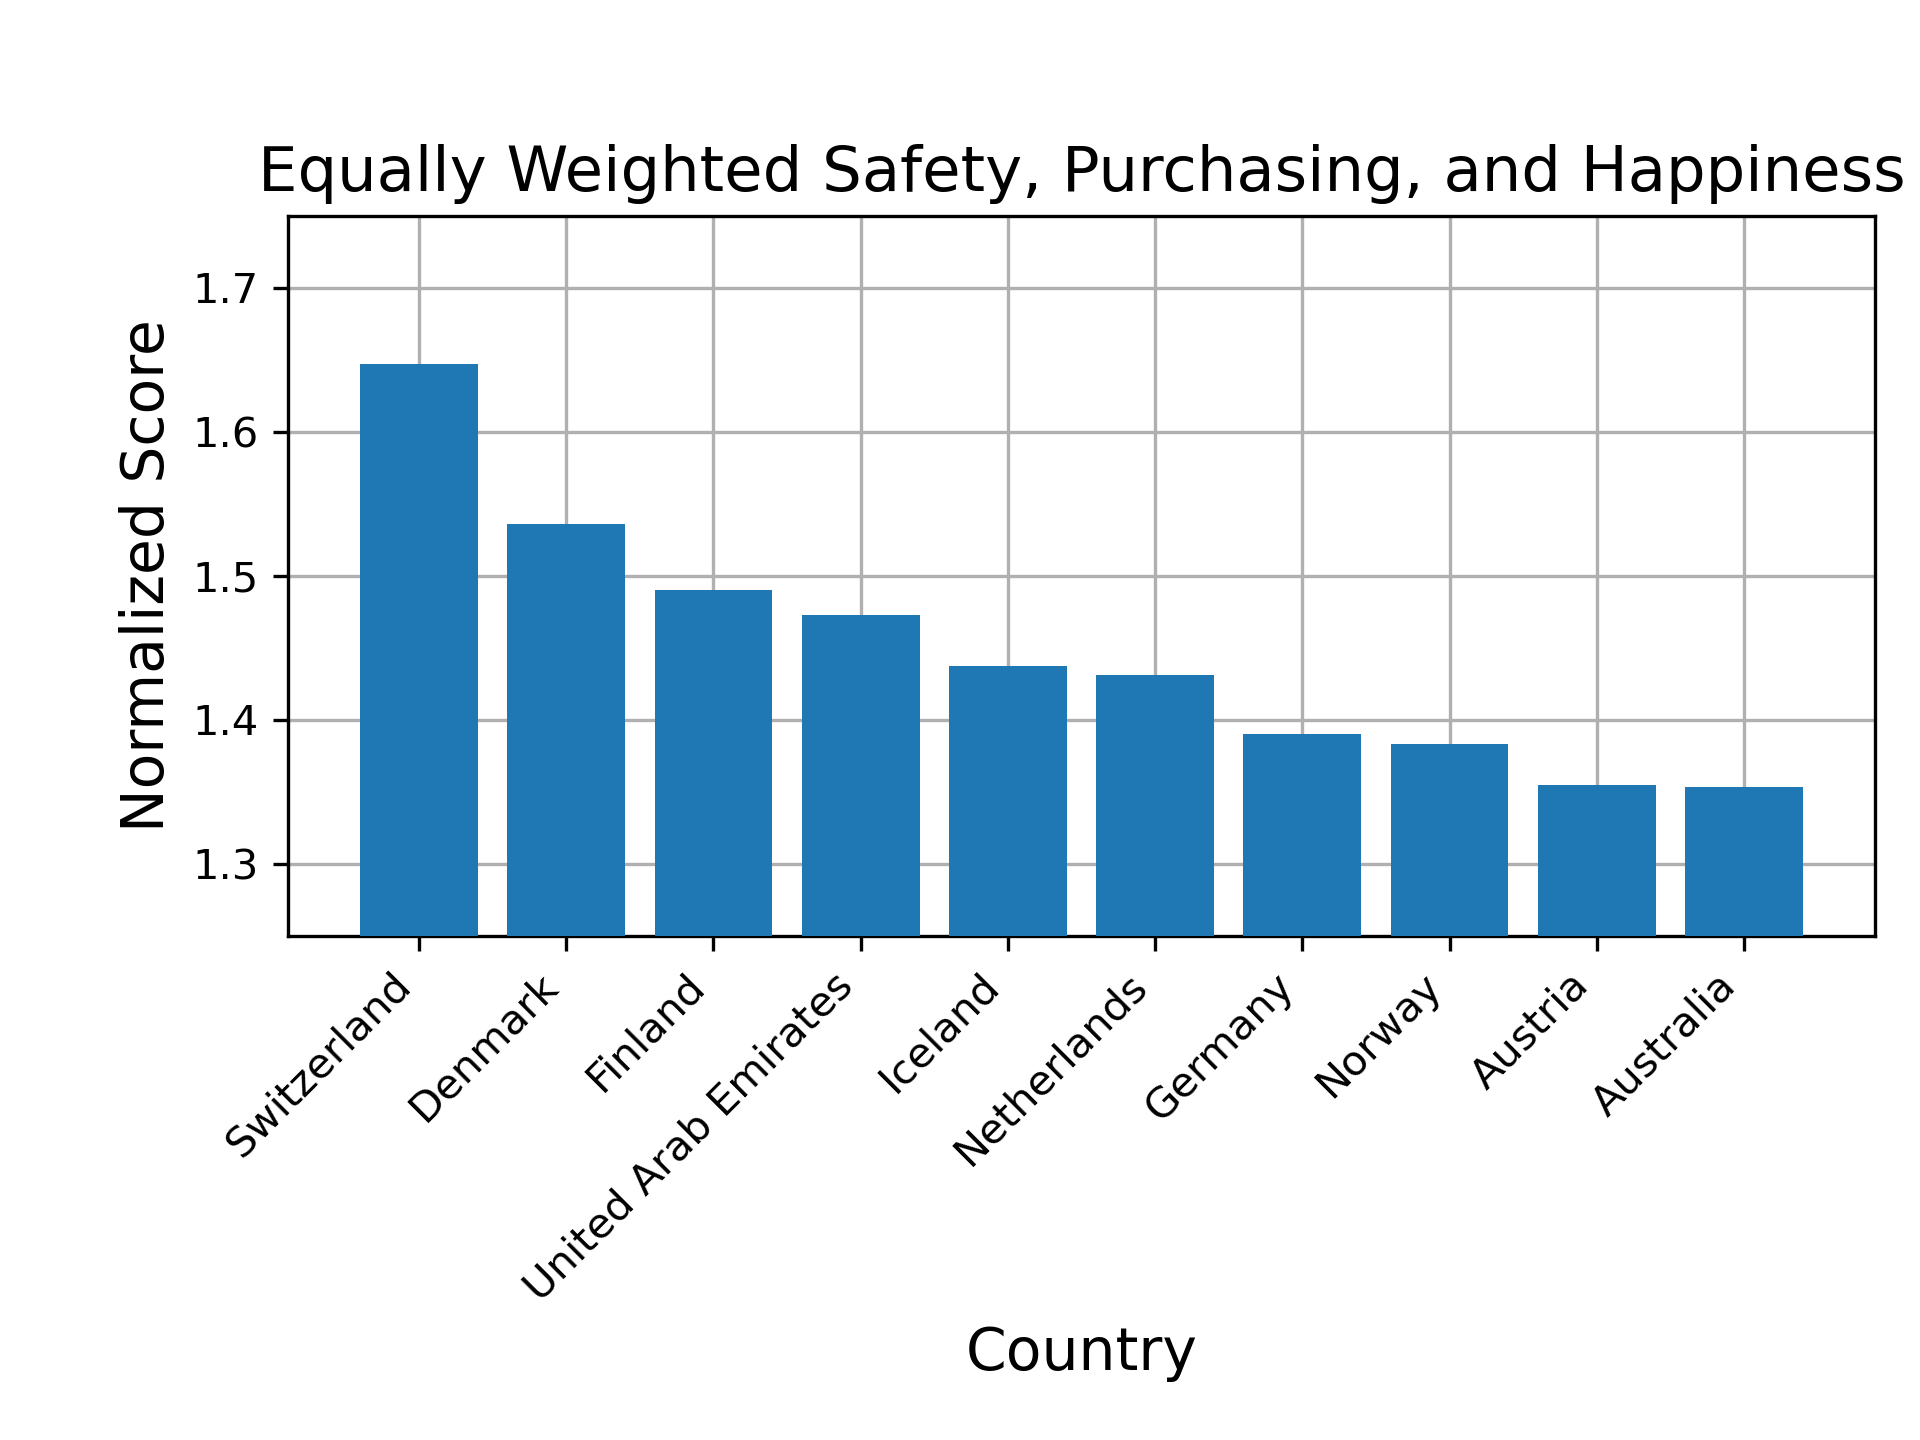

In [47]:
#Equally Weighted
%matplotlib notebook
x = top10EquallyWeighted['Country']
height = top10EquallyWeighted['Equally Weighted Safety, Purchasing, and Happiness']


# collecting countries
countriesOfInterestSet = set()
for q in x:
    countriesOfInterestSet.add(q)
fig, ax = plt.subplots()
ax.bar(x, height, zorder=5) 
plt.xticks(rotation = 45, ha='right')
plt.tight_layout()
plt.subplots_adjust(top=.85, left=0.15, bottom=0.35)
plt.title('Equally Weighted Safety, Purchasing, and Happiness', fontsize=15)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Normalized Score', fontsize=14)
plt.ylim(1.25, 1.75)
plt.grid(zorder=0)
fig1 = plt.gcf()
plt.show()

In [48]:
# Create png name
figureTitle = 'EquallyWeightedSafPurchHap9'

# Save the figure
fig1.savefig(f"Output/{figureTitle}.png")

<IPython.core.display.Javascript object>


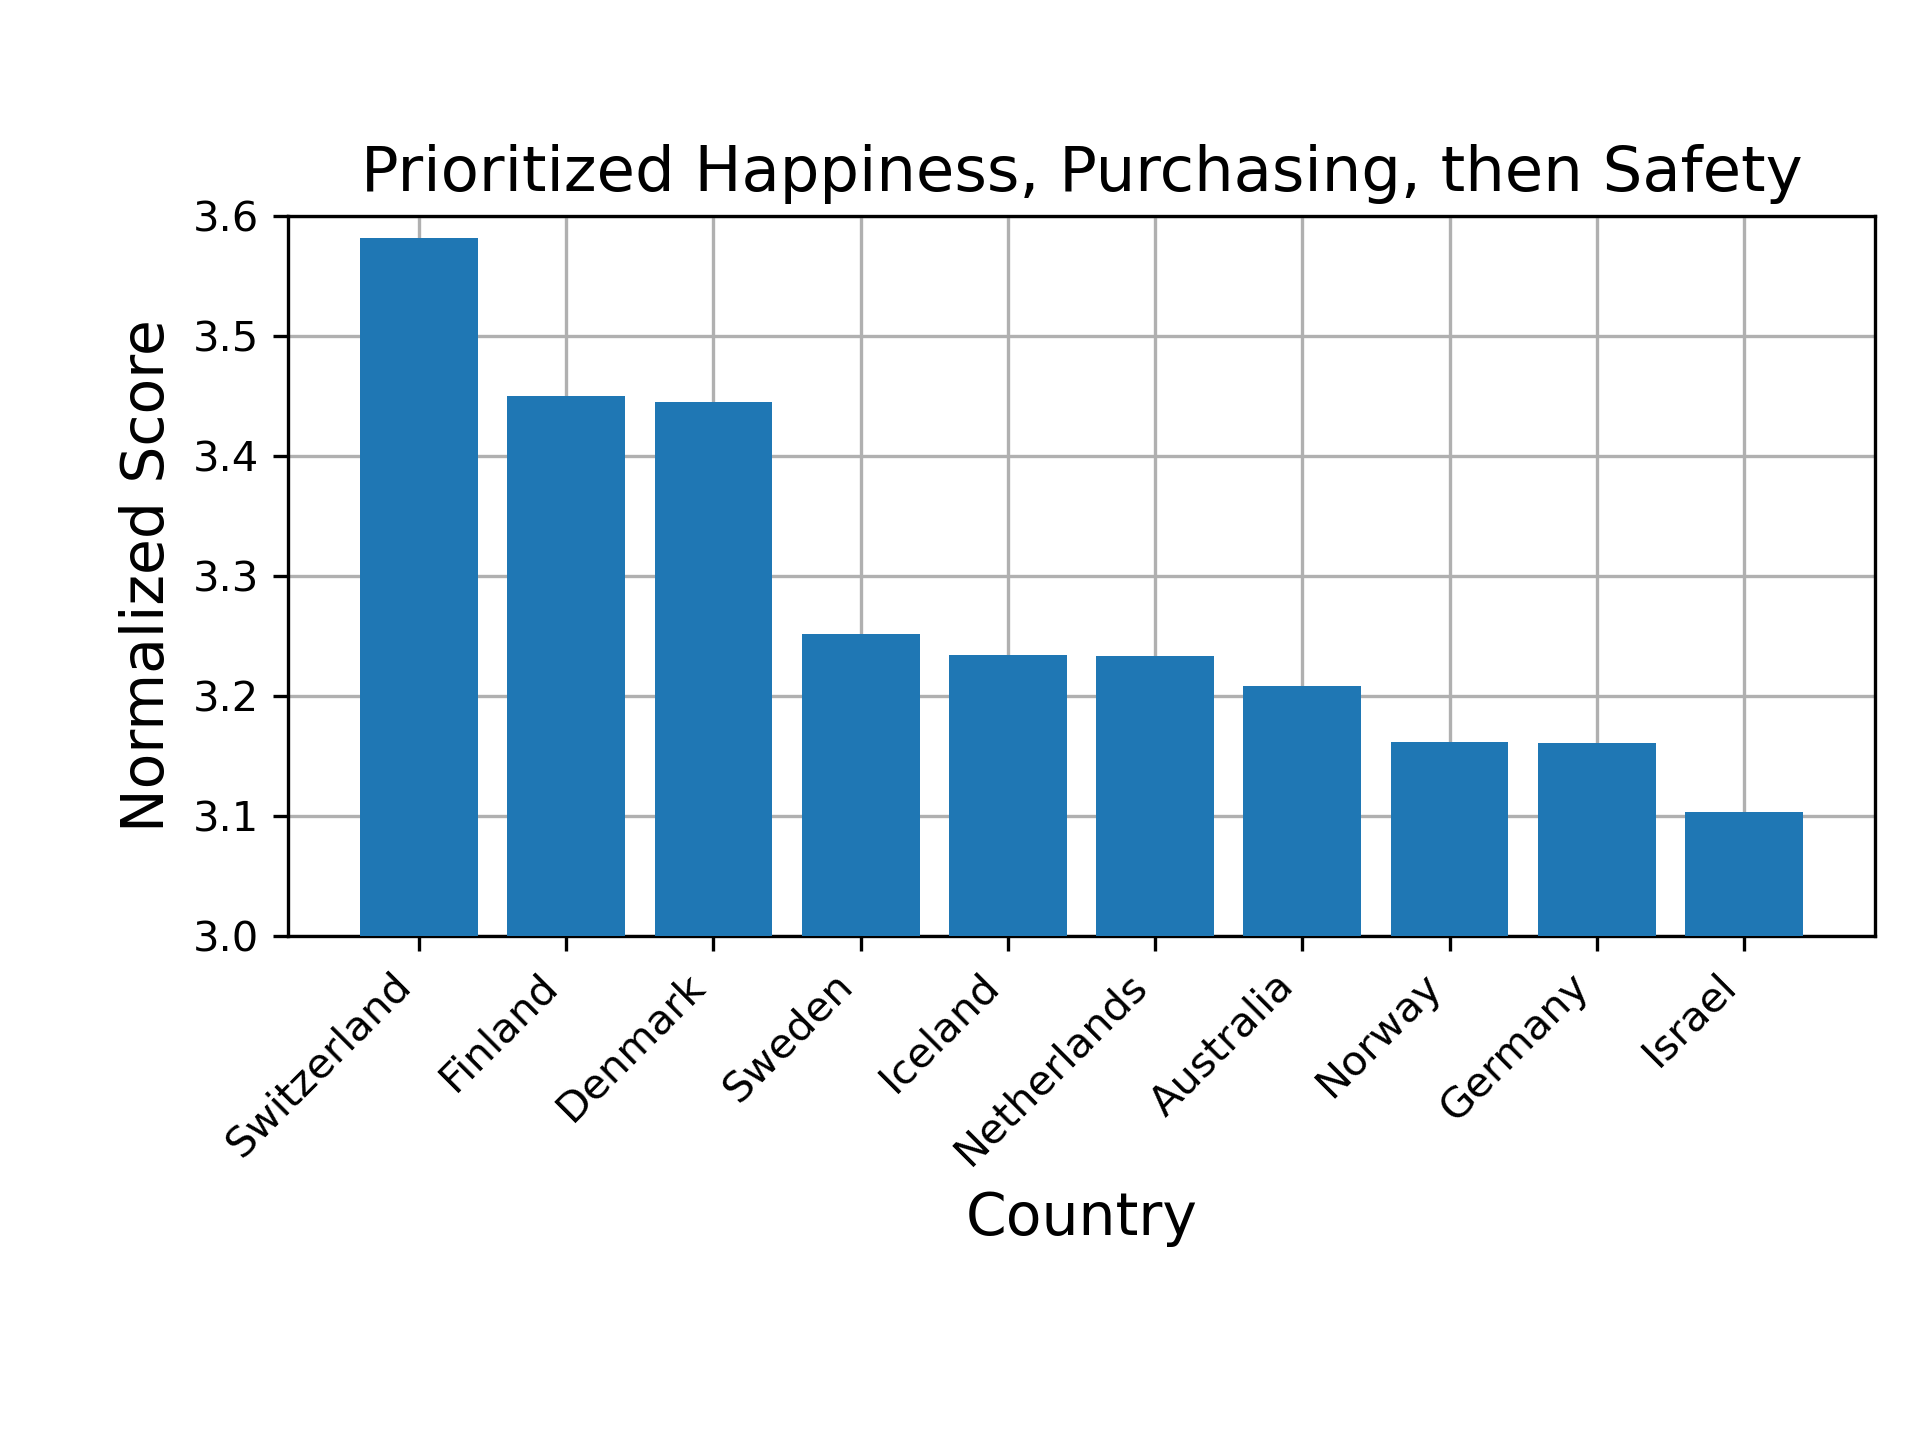

In [49]:
#Happiness 3, purch 2, safety 1
%matplotlib notebook
weightHap = 3
weightPurch = 2
weightSafety = 1
HappinessCostOfLivingCrime_df['Prioritized Happiness, Purchasing, then Safety'] = np.sqrt((HappinessCostOfLivingCrime_df['Normalized Safety'] * weightSafety)**2 + 
                            (HappinessCostOfLivingCrime_df['Normalized Local Purchasing Power'] * weightPurch)**2 + 
                            (HappinessCostOfLivingCrime_df['Normalized Happiness'] * weightHap)**2)
top10Prioritized = HappinessCostOfLivingCrime_df.sort_values('Prioritized Happiness, Purchasing, then Safety', 
                                               ascending=False).head(10)
x = top10Prioritized['Country']
height = top10Prioritized['Prioritized Happiness, Purchasing, then Safety']


# collecting countries
for q in x:     
    countriesOfInterestSet.add(q)

fig, ax = plt.subplots()
ax.bar(x, height, zorder=5) 
plt.xticks(rotation = 45, ha='right')
plt.tight_layout()
plt.subplots_adjust(top=.85, left=0.15, bottom=0.35)
plt.title('Prioritized Happiness, Purchasing, then Safety', fontsize=15)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Normalized Score', fontsize=14)
plt.ylim(3, 3.6)
plt.grid(zorder=0)
fig1 = plt.gcf()
plt.show()

In [50]:
# Create png name
figureTitle = 'PrioritizedHapPurchSaf10'

# Save the figure
fig1.savefig(f"Output/{figureTitle}.png")

<IPython.core.display.Javascript object>


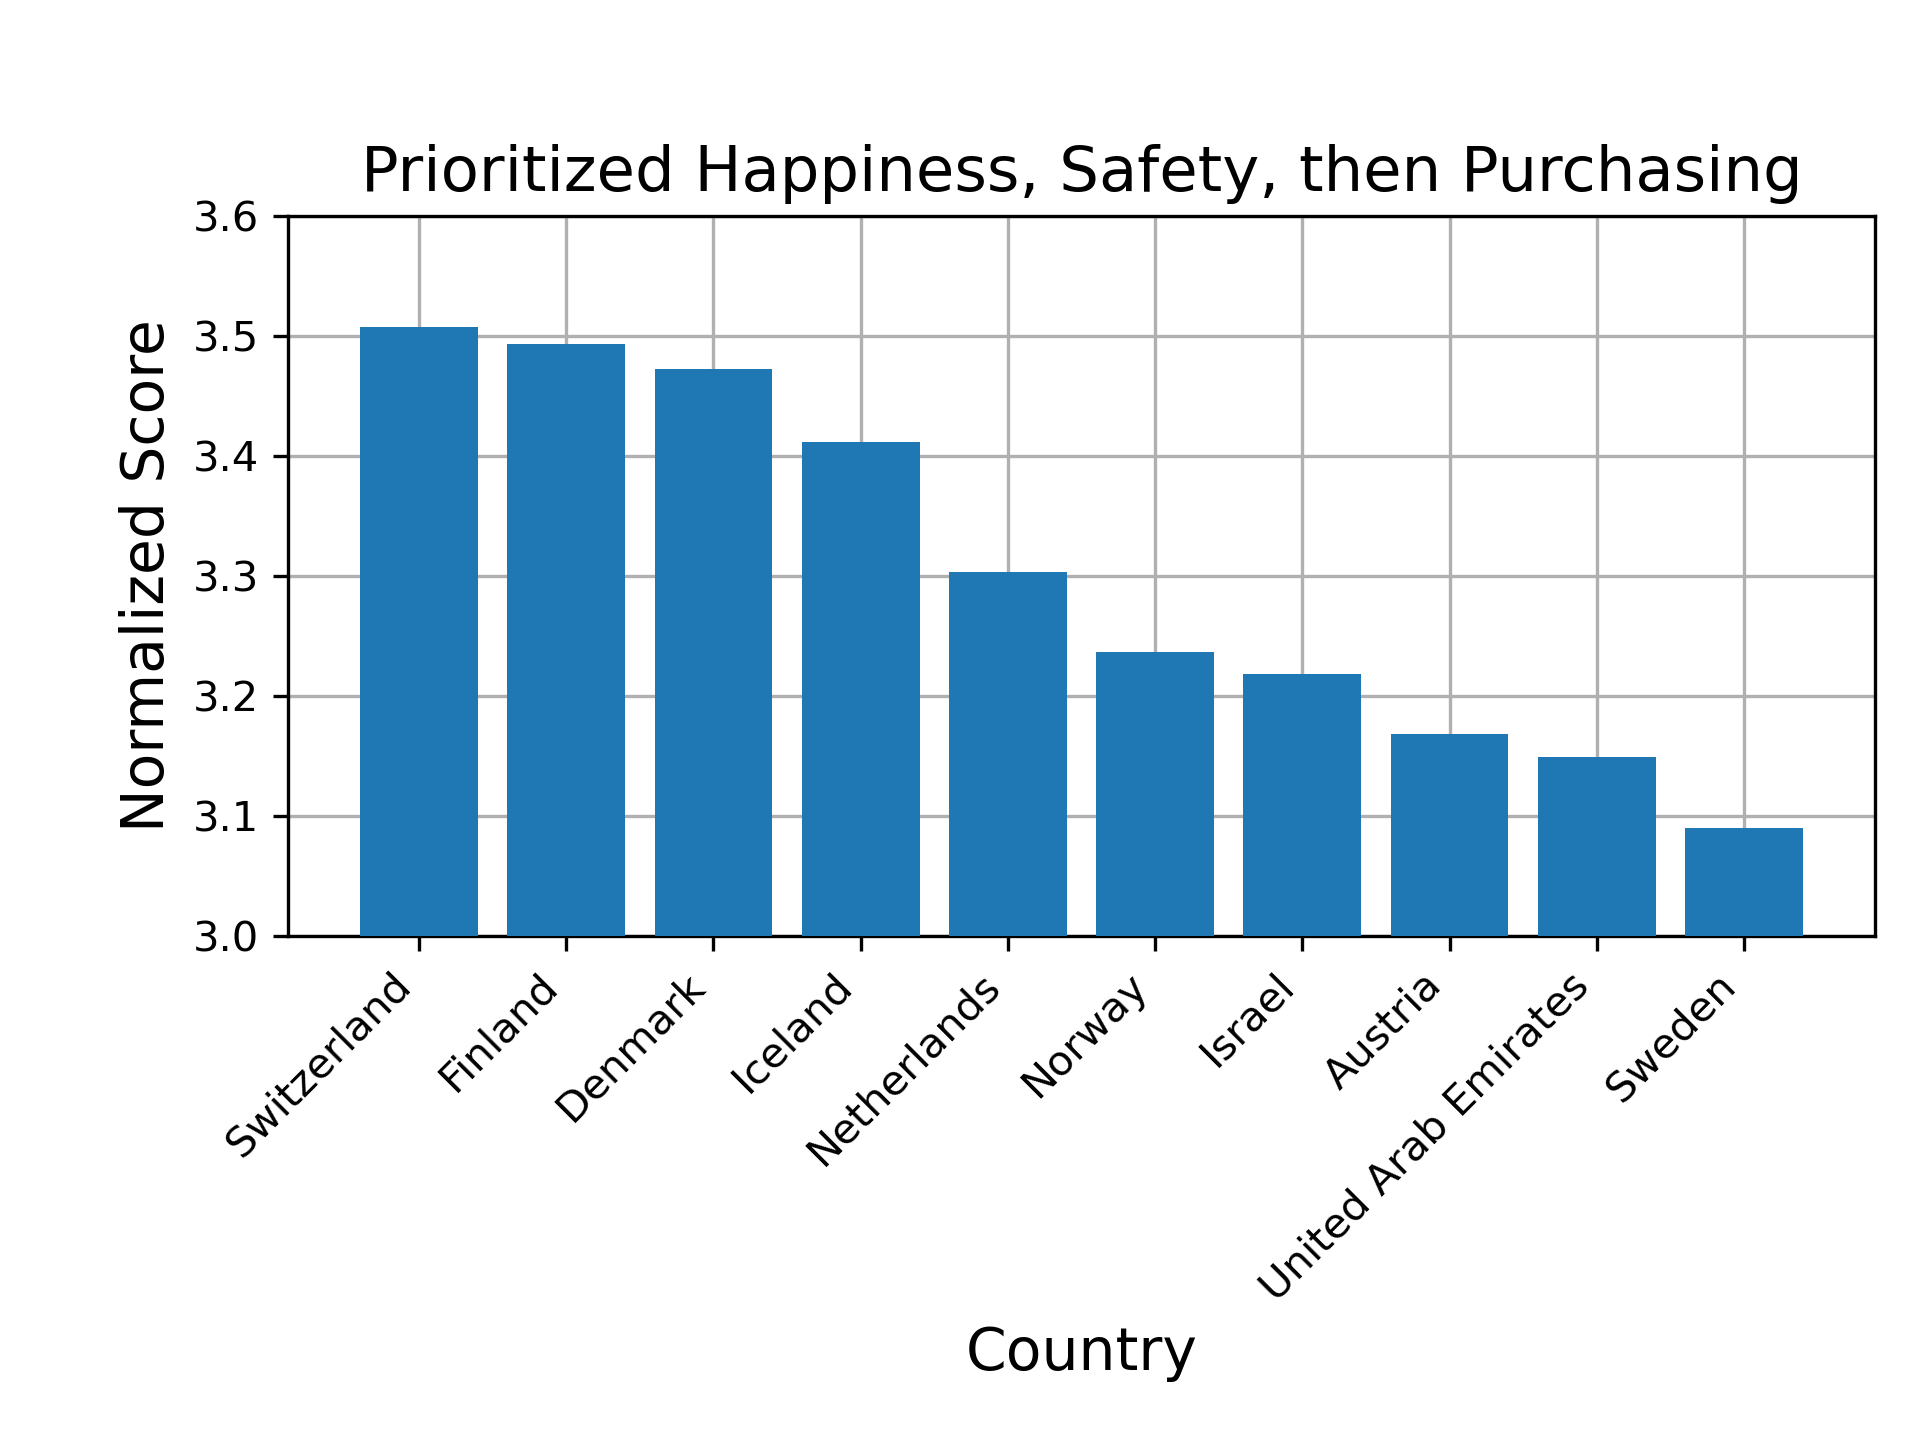

In [51]:
#Happiness 3, purch 1, safety 2
%matplotlib notebook
weightHap = 3
weightPurch = 1
weightSafety = 2
HappinessCostOfLivingCrime_df['Prioritized Happiness, Safety, then Purchasing'] = np.sqrt((HappinessCostOfLivingCrime_df['Normalized Safety'] * weightSafety)**2 + 
                            (HappinessCostOfLivingCrime_df['Normalized Local Purchasing Power'] * weightPurch)**2 + 
                            (HappinessCostOfLivingCrime_df['Normalized Happiness'] * weightHap)**2)
top10Prioritized = HappinessCostOfLivingCrime_df.sort_values('Prioritized Happiness, Safety, then Purchasing', 
                                               ascending=False).head(10)
# print(top10Prioritized[['Country','Prioritized Happiness, Safety, then Purchasing']])
x = top10Prioritized['Country']
height = top10Prioritized['Prioritized Happiness, Safety, then Purchasing']


# collecting countries
for q in x:     
    countriesOfInterestSet.add(q)

fig, ax = plt.subplots()
ax.bar(x, height, zorder=5) 
plt.xticks(rotation = 45, ha='right')
plt.tight_layout()
plt.subplots_adjust(top=.85, left=0.15, bottom=0.35)
plt.title('Prioritized Happiness, Safety, then Purchasing', fontsize=15)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Normalized Score', fontsize=14)
plt.ylim(3, 3.6)
plt.grid(zorder=0)
fig1 = plt.gcf()
plt.show()

In [52]:
# Create png name
figureTitle = 'PrioritizedHapSafPurch11'

# Save the figure
fig1.savefig(f"Output/{figureTitle}.png")

<IPython.core.display.Javascript object>


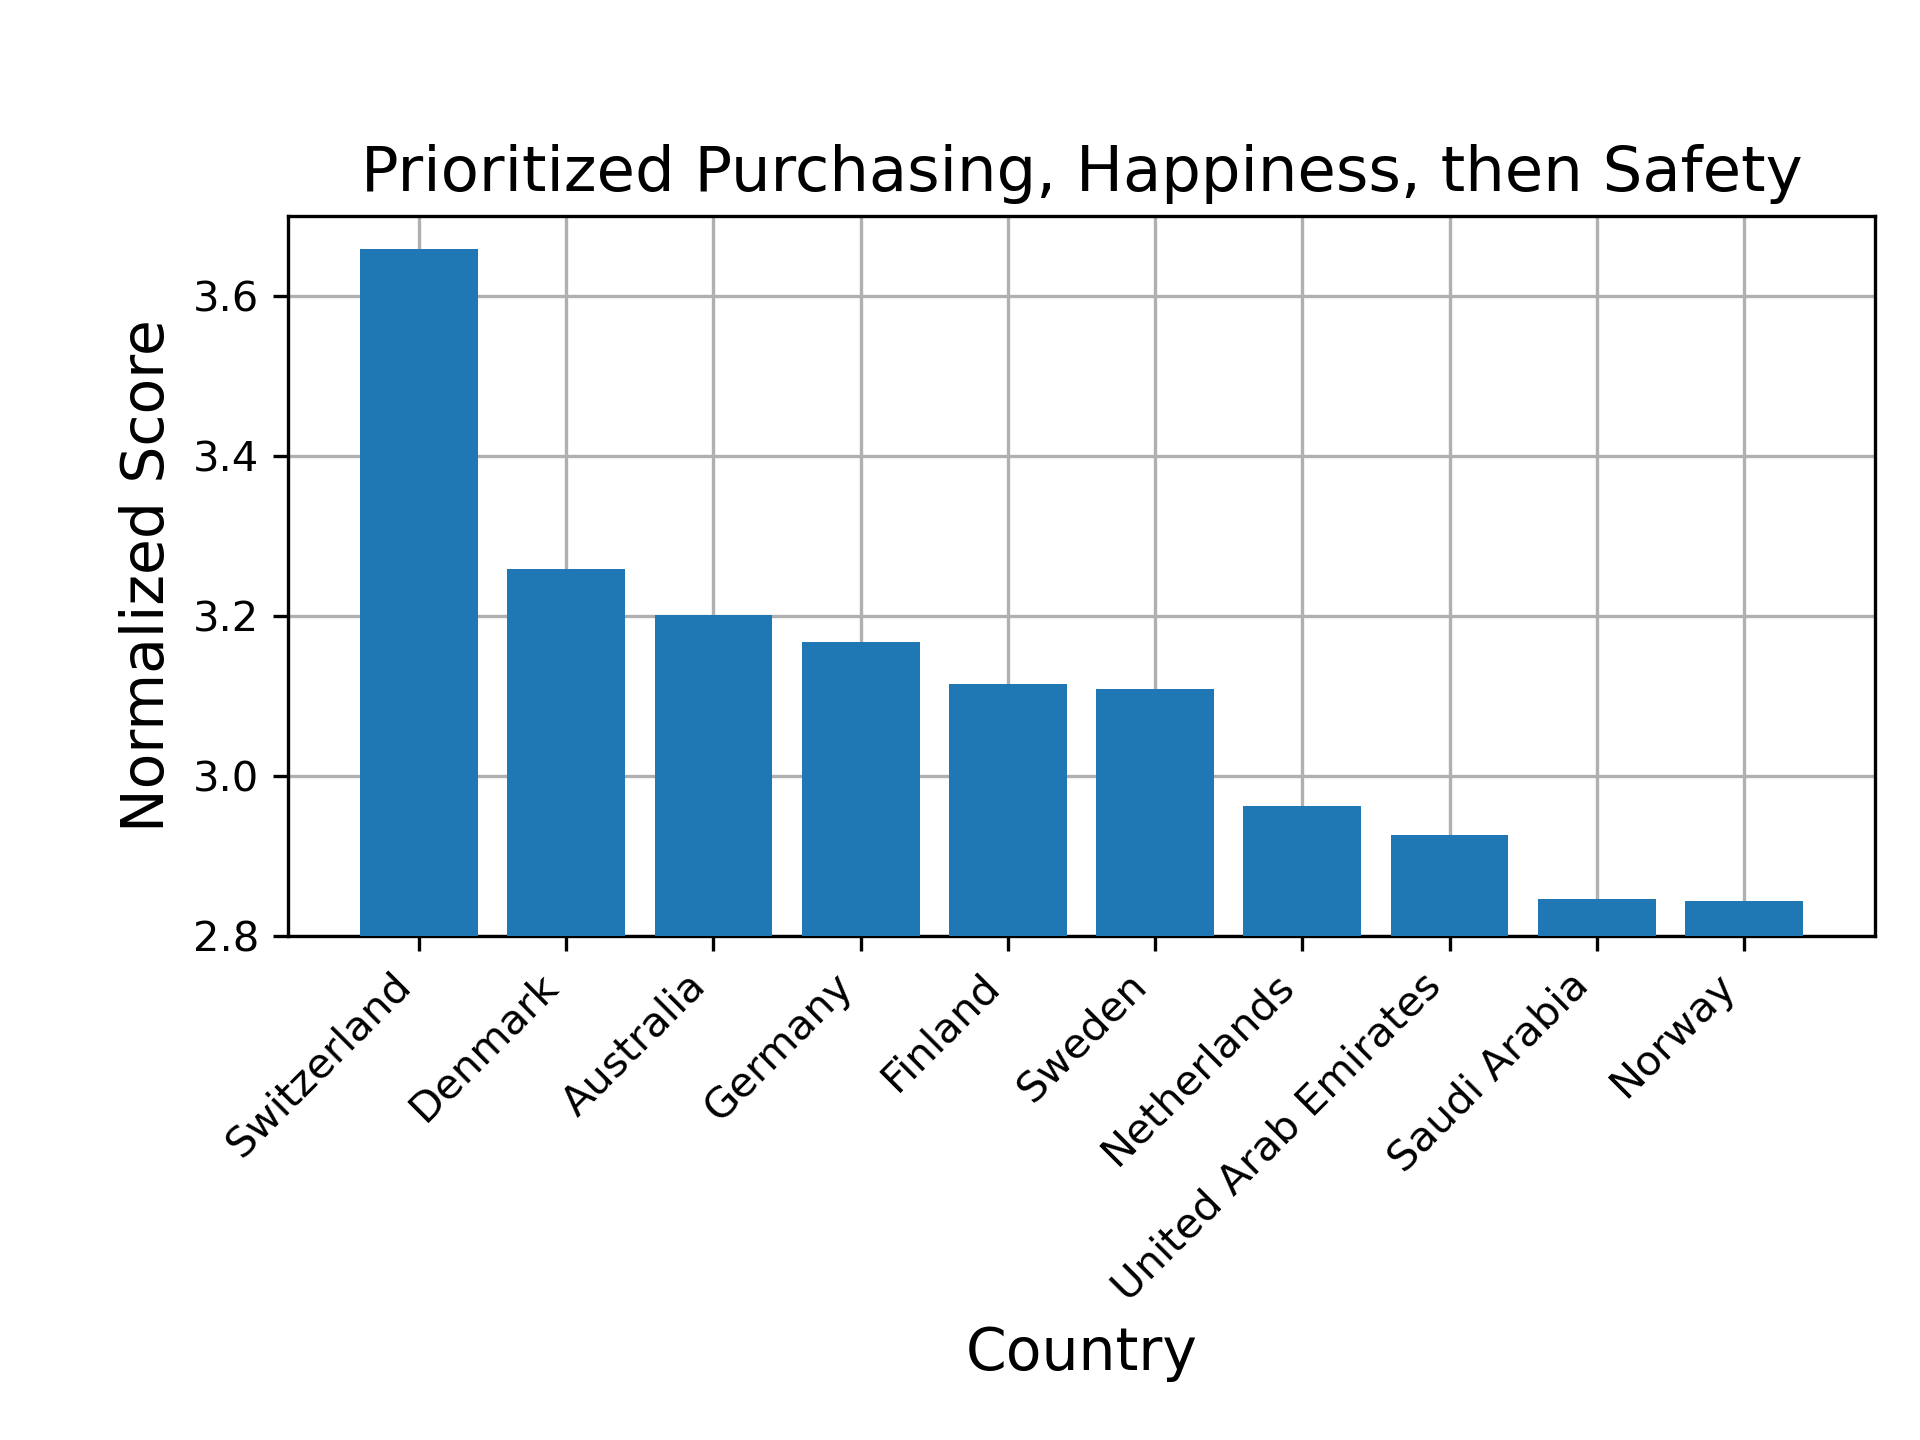

{'United Arab Emirates', 'Norway', 'Australia', 'Switzerland', 'Denmark', 'Netherlands', 'Israel', 'Saudi Arabia', 'Germany', 'Sweden', 'Finland', 'Austria', 'Iceland'}


In [53]:
#Happiness 2, purch 3, safety 1
%matplotlib notebook
weightHap = 2
weightPurch = 3
weightSafety = 1
HappinessCostOfLivingCrime_df['Prioritized Purchasing, Happiness, then Safety'] = np.sqrt((HappinessCostOfLivingCrime_df['Normalized Safety'] * weightSafety)**2 + 
                            (HappinessCostOfLivingCrime_df['Normalized Local Purchasing Power'] * weightPurch)**2 + 
                            (HappinessCostOfLivingCrime_df['Normalized Happiness'] * weightHap)**2)
top10Prioritized = HappinessCostOfLivingCrime_df.sort_values('Prioritized Purchasing, Happiness, then Safety', 
                                               ascending=False).head(10)
# print(HappinessCostOfLivingCrime_df.count())
x = top10Prioritized['Country']
height = top10Prioritized['Prioritized Purchasing, Happiness, then Safety']

# collecting countries
for q in x:     
    countriesOfInterestSet.add(q)

fig, ax = plt.subplots()
ax.bar(x, height, zorder=5) 
plt.xticks(rotation = 45, ha='right')
plt.tight_layout()
plt.subplots_adjust(top=.85, left=0.15, bottom=0.35)
plt.title('Prioritized Purchasing, Happiness, then Safety', fontsize=15)
plt.xlabel('Country', fontsize=14)
plt.ylim(2.8, 3.7)
plt.ylabel('Normalized Score', fontsize=14)
plt.grid(zorder=0)
print(countriesOfInterestSet)
fig1 = plt.gcf()
plt.show()

In [54]:
# Create png name
figureTitle = 'PrioritizedPurchHapSaf12'

# Save the figure
fig1.savefig(f"Output/{figureTitle}.png")

<IPython.core.display.Javascript object>


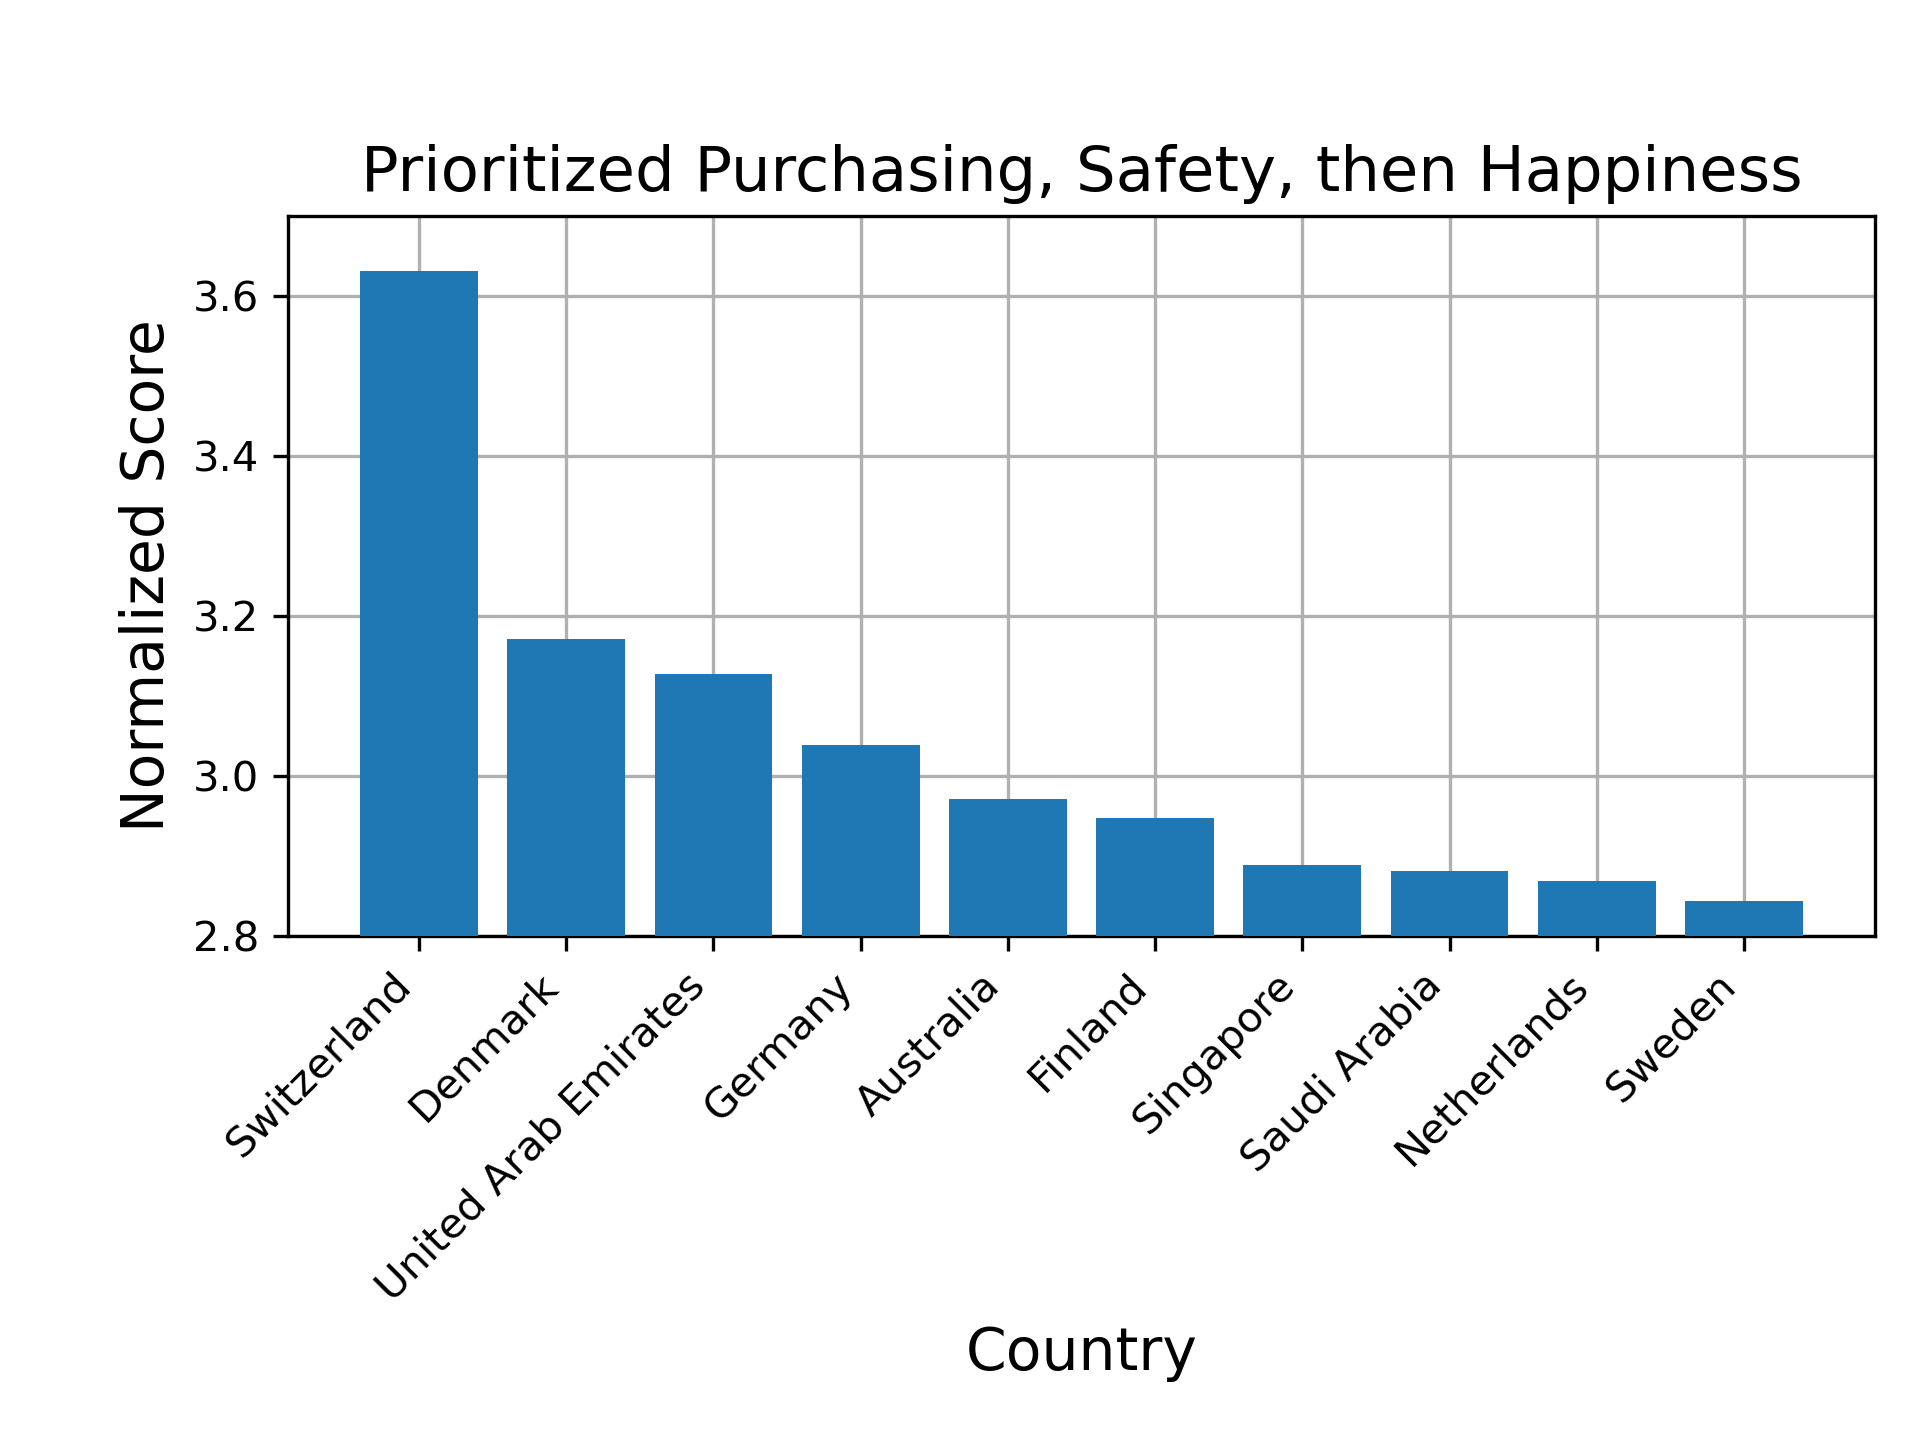

In [55]:
#Happiness 1, purch 3, safety 2
%matplotlib notebook
weightHap = 1
weightPurch = 3
weightSafety = 2
HappinessCostOfLivingCrime_df['Prioritized Purchasing, Safety, then Happiness'] = np.sqrt((HappinessCostOfLivingCrime_df['Normalized Safety'] * weightSafety)**2 + 
                            (HappinessCostOfLivingCrime_df['Normalized Local Purchasing Power'] * weightPurch)**2 + 
                            (HappinessCostOfLivingCrime_df['Normalized Happiness'] * weightHap)**2)
top10Prioritized = HappinessCostOfLivingCrime_df.sort_values('Prioritized Purchasing, Safety, then Happiness', 
                                               ascending=False).head(10)
# print(HappinessCostOfLivingCrime_df.count())
x = top10Prioritized['Country']
height = top10Prioritized['Prioritized Purchasing, Safety, then Happiness']

# collecting countries
for q in x:     
    countriesOfInterestSet.add(q)

fig, ax = plt.subplots()
ax.bar(x, height, zorder=5) 
plt.xticks(rotation = 45, ha='right')
plt.tight_layout()
plt.subplots_adjust(top=.85, left=0.15, bottom=0.35)
plt.title('Prioritized Purchasing, Safety, then Happiness', fontsize=15)
plt.xlabel('Country', fontsize=14)
plt.ylim(2.8, 3.7)
plt.ylabel('Normalized Score', fontsize=14)
plt.grid(zorder=0)
fig1 = plt.gcf()
plt.show()

In [56]:
# Create png name
figureTitle = 'PrioritizedPurchSafHap13'

# Save the figure
fig1.savefig(f"Output/{figureTitle}.png")

<IPython.core.display.Javascript object>


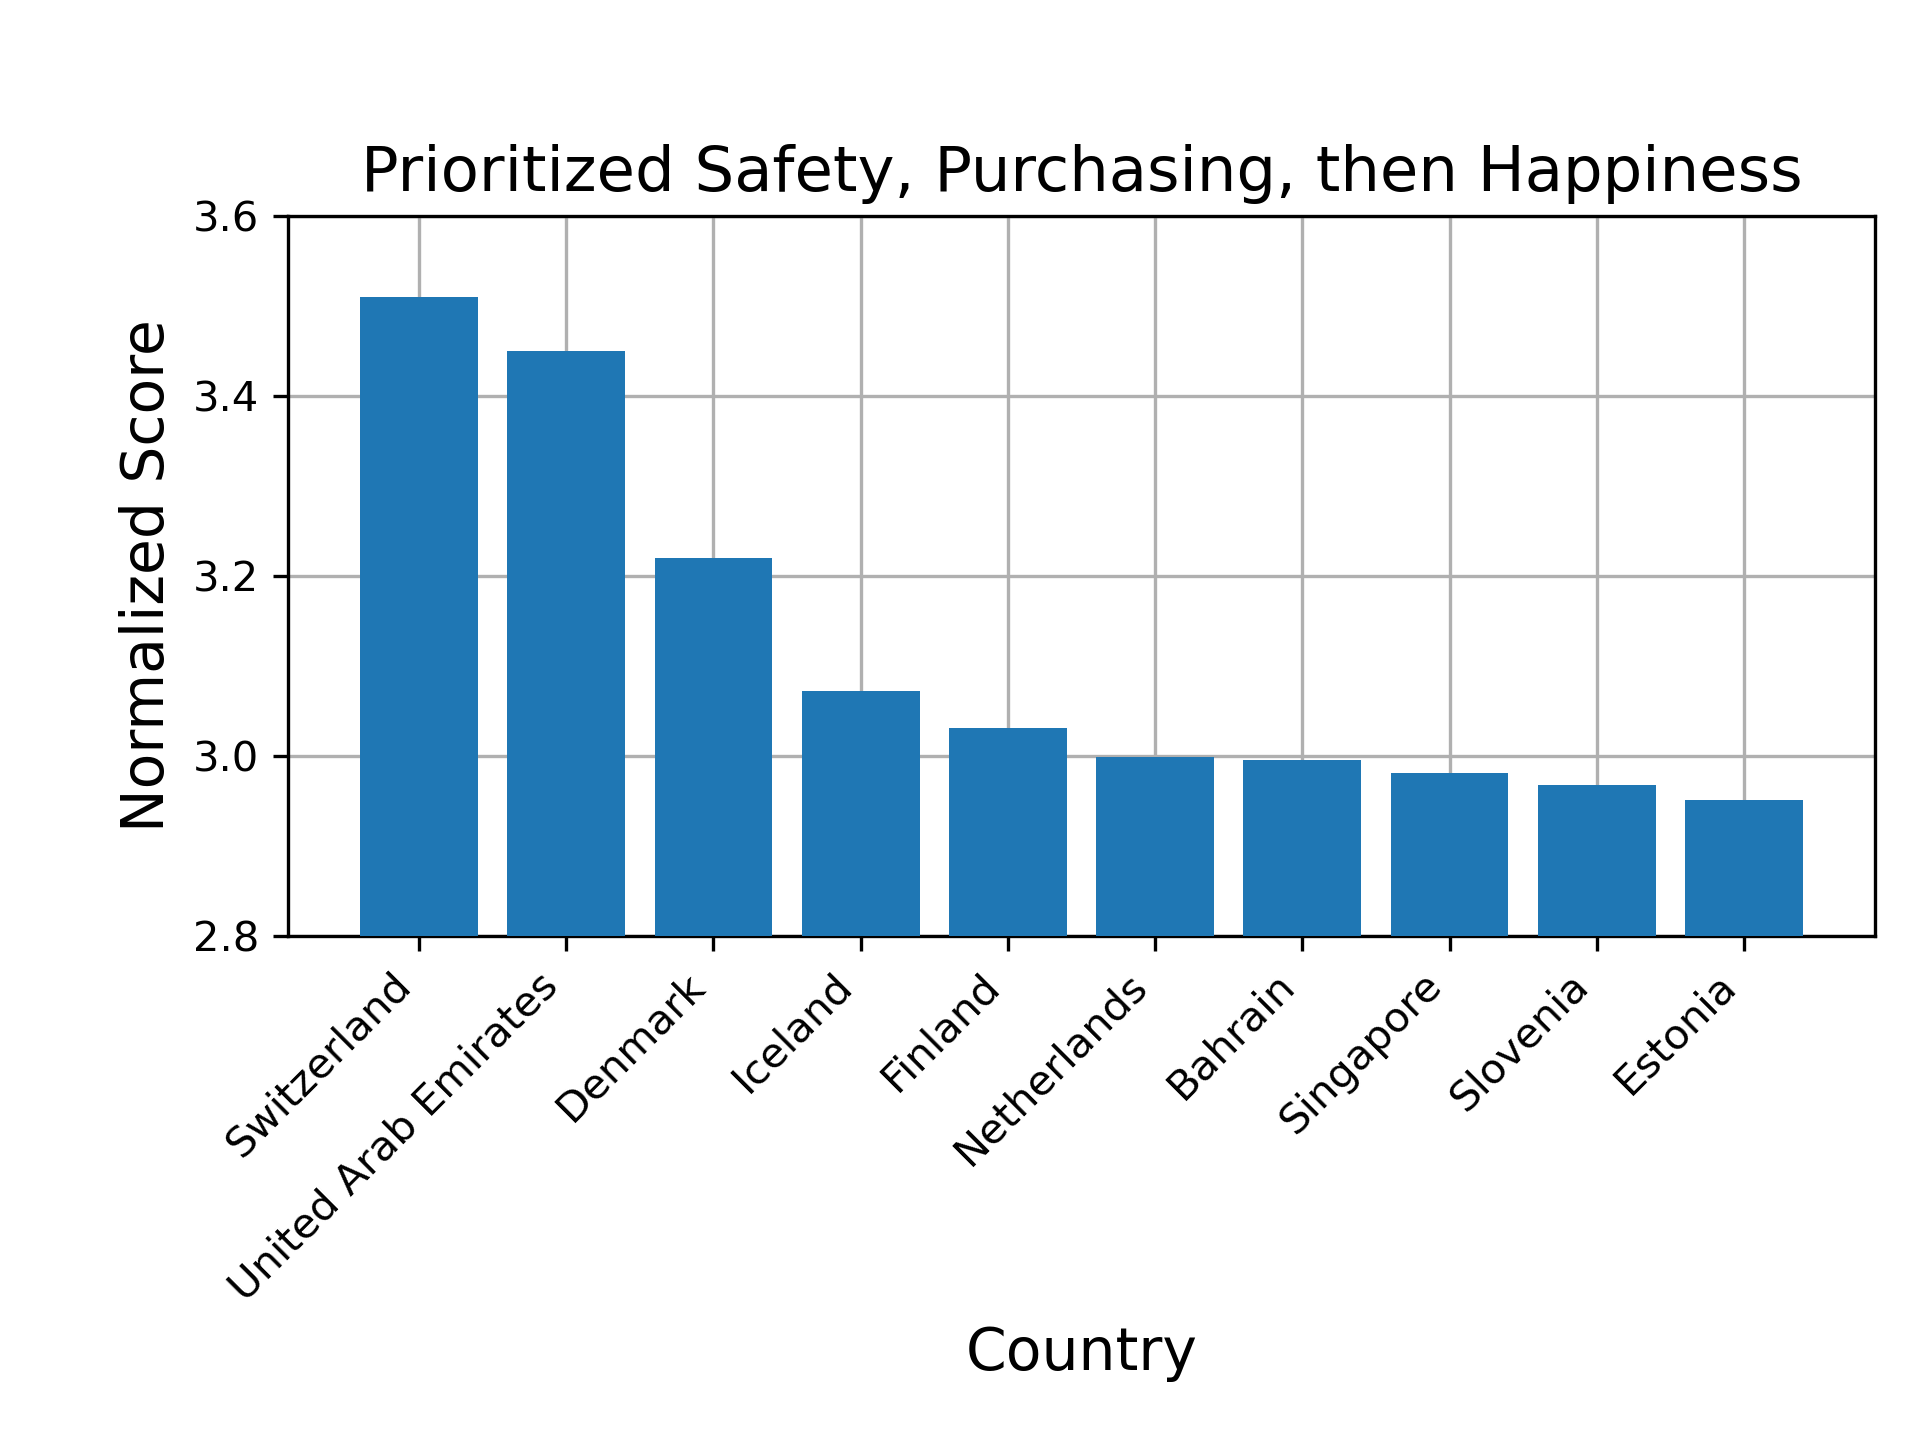

In [57]:
#Happiness 1, purch 2, safety 3
%matplotlib notebook
weightHap = 1
weightPurch = 2
weightSafety = 3
HappinessCostOfLivingCrime_df['Prioritized Safety, Purchasing, then Happiness'] = np.sqrt((HappinessCostOfLivingCrime_df['Normalized Safety'] * weightSafety)**2 + 
                            (HappinessCostOfLivingCrime_df['Normalized Local Purchasing Power'] * weightPurch)**2 + 
                            (HappinessCostOfLivingCrime_df['Normalized Happiness'] * weightHap)**2)
top10Prioritized = HappinessCostOfLivingCrime_df.sort_values('Prioritized Safety, Purchasing, then Happiness', 
                                               ascending=False).head(10)
# print(HappinessCostOfLivingCrime_df.count())
x = top10Prioritized['Country']
height = top10Prioritized['Prioritized Safety, Purchasing, then Happiness']

# collecting countries
for q in x:     
    countriesOfInterestSet.add(q)

fig, ax = plt.subplots()
ax.bar(x, height, zorder=5) 
plt.xticks(rotation = 45, ha='right')
plt.tight_layout()
plt.subplots_adjust(top=.85, left=0.15, bottom=0.35)
plt.title('Prioritized Safety, Purchasing, then Happiness', fontsize=15)
plt.xlabel('Country', fontsize=14)
plt.ylim(2.8, 3.6)
plt.ylabel('Normalized Score', fontsize=14)
plt.grid(zorder=0)
fig1 = plt.gcf()
plt.show()

In [58]:
# Create png name
figureTitle = 'PrioritizedSafPurchHap14'

# Save the figure
fig1.savefig(f"Output/{figureTitle}.png")

<IPython.core.display.Javascript object>


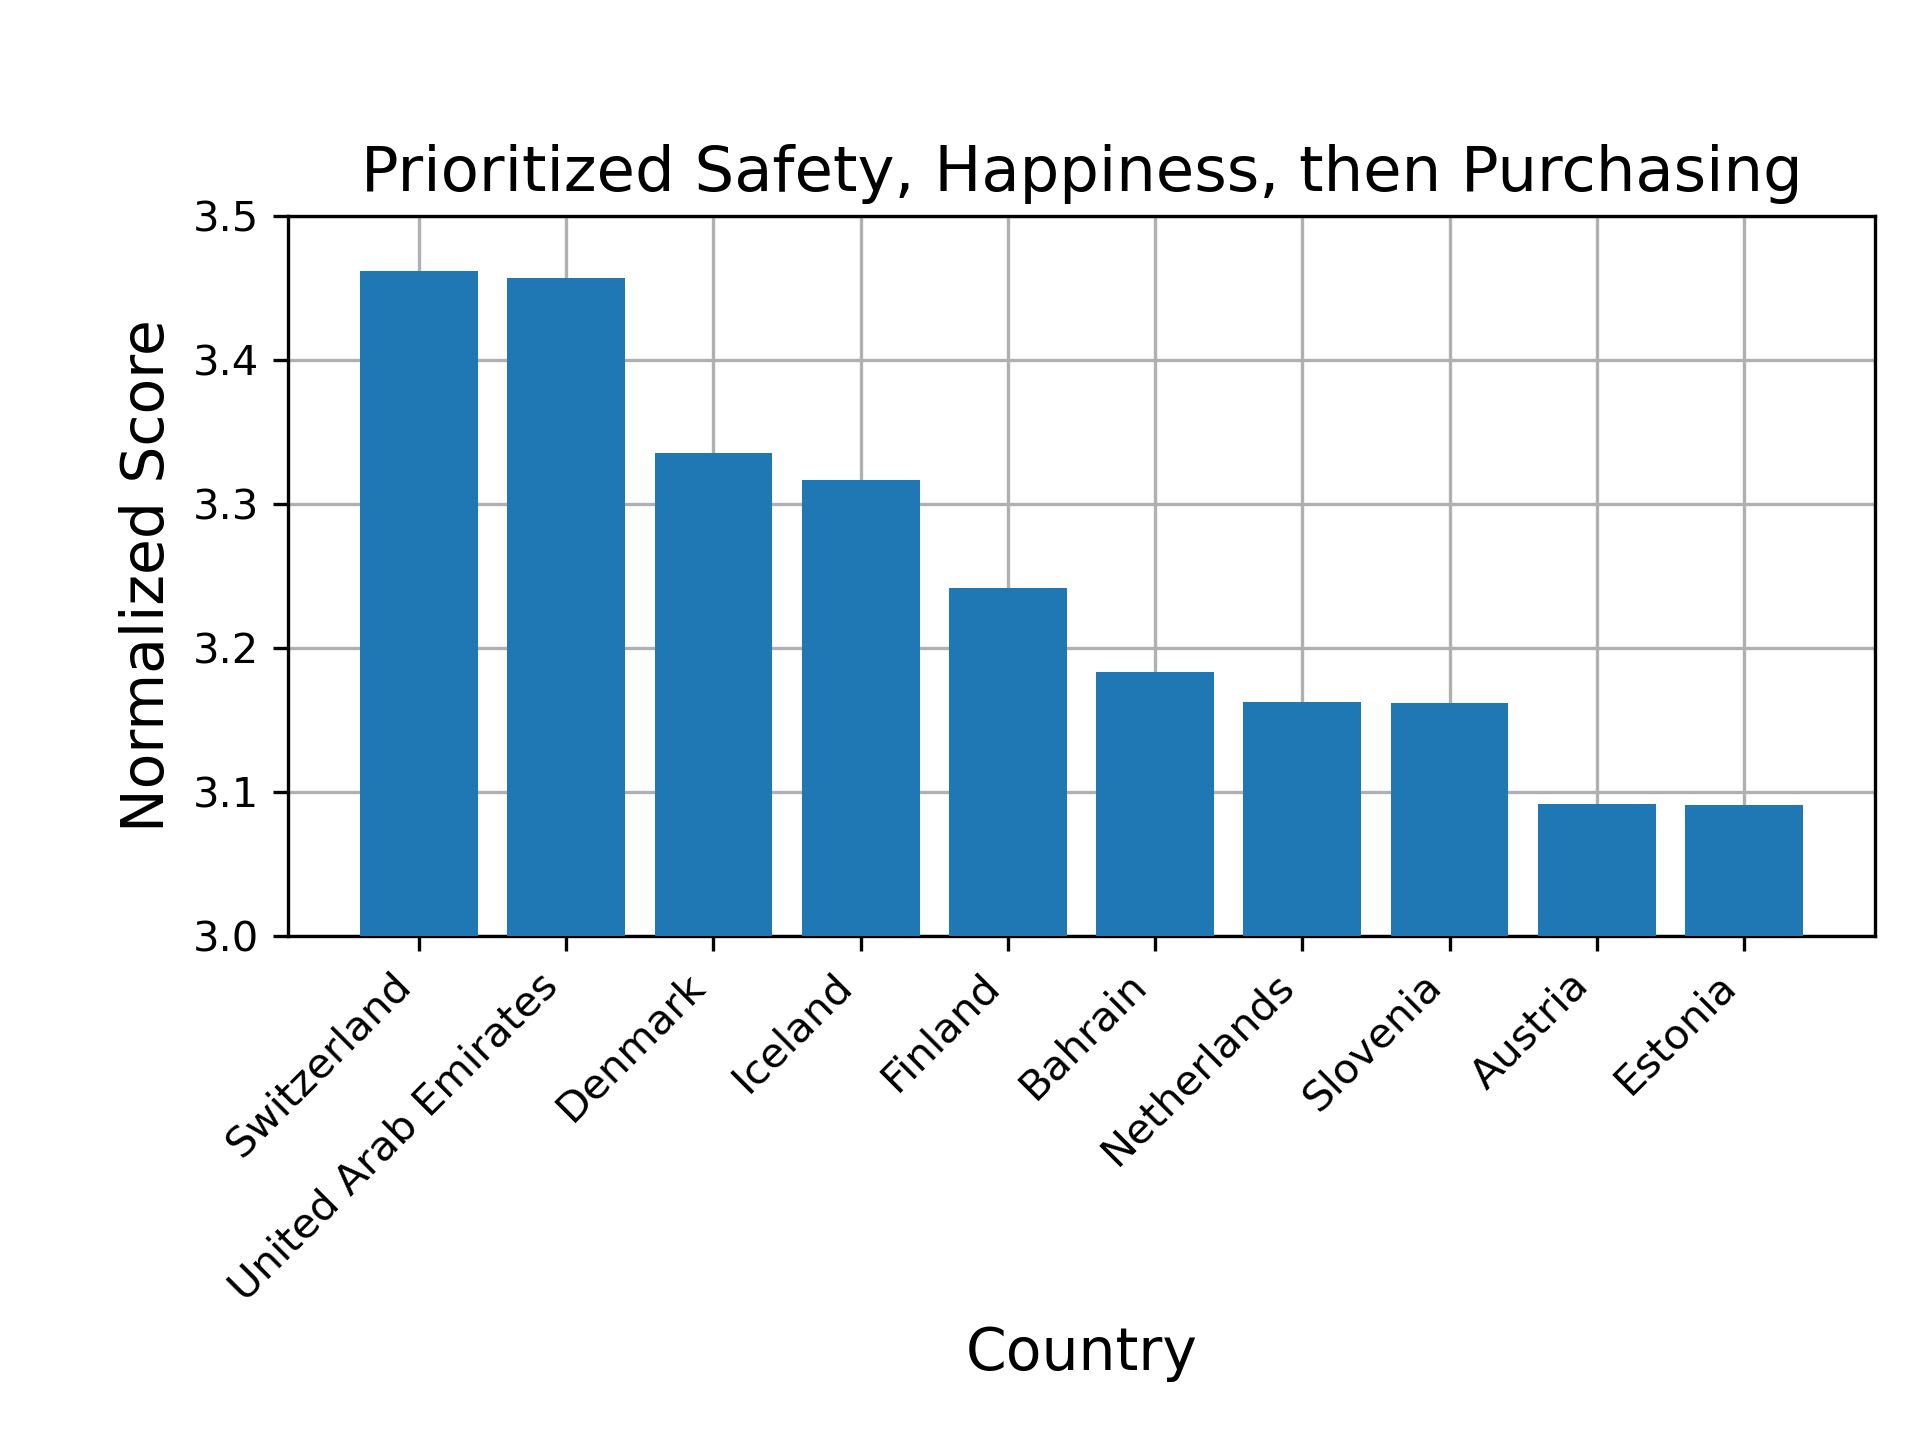

In [59]:
#Happiness 2, purch 1, safety 3
%matplotlib notebook
weightHap = 2
weightPurch = 1
weightSafety = 3
HappinessCostOfLivingCrime_df['Prioritized Safety, Happiness, then Purchasing'] = np.sqrt((HappinessCostOfLivingCrime_df['Normalized Safety'] * weightSafety)**2 + 
                            (HappinessCostOfLivingCrime_df['Normalized Local Purchasing Power'] * weightPurch)**2 + 
                            (HappinessCostOfLivingCrime_df['Normalized Happiness'] * weightHap)**2)
top10Prioritized = HappinessCostOfLivingCrime_df.sort_values('Prioritized Safety, Happiness, then Purchasing', 
                                               ascending=False).head(10)
# print(HappinessCostOfLivingCrime_df.count())
x = top10Prioritized['Country']
height = top10Prioritized['Prioritized Safety, Happiness, then Purchasing']

# collecting countries
for q in x:     
    countriesOfInterestSet.add(q)

fig, ax = plt.subplots()
ax.bar(x, height, zorder=5) 
plt.xticks(rotation = 45, ha='right')
plt.tight_layout()
plt.subplots_adjust(top=.85, left=0.15, bottom=0.35)
plt.title('Prioritized Safety, Happiness, then Purchasing', fontsize=15)
plt.xlabel('Country', fontsize=14)
plt.ylim(3, 3.5)
plt.ylabel('Normalized Score', fontsize=14)
plt.grid(zorder=0)
fig1 = plt.gcf()
plt.show()

In [60]:
# Create png name
figureTitle = 'PrioritizedSafHapPurch15'

# Save the figure
fig1.savefig(f"Output/{figureTitle}.png")

In [61]:
# Save dataFrame to csv
HappinessCostOfLivingCrime_df.to_csv('./Output/CSVSavePoint/HappinessCostOfLivingCrime_dfHist.csv')
# Save countriesOfInterestSet
with open('./Output/CSVSavePoint/countriesOfInterestSet.txt', 'w') as file:
    file.write(str(countriesOfInterestSet).replace("'","").replace("{","").replace("}",""))
countriesOfInterestSet

{'Australia',
 'Austria',
 'Bahrain',
 'Denmark',
 'Estonia',
 'Finland',
 'Germany',
 'Iceland',
 'Israel',
 'Netherlands',
 'Norway',
 'Saudi Arabia',
 'Singapore',
 'Slovenia',
 'Sweden',
 'Switzerland',
 'United Arab Emirates'}

In [62]:
#********************************************
# Create a dataframe loading point in order to skip steps in the event of having to restart the kernel
HappinessCostOfLivingCrime_df = pd.read_csv('./Output/CSVSavePoint/HappinessCostOfLivingCrime_dfHist.csv')

# Load countriesOfInterestSet
with open('./Output/CSVSavePoint/countriesOfInterestSet.txt', 'r') as file:
    countriesOfInterestSet = set(file.read().replace(", ",",").split(","))
countriesOfInterestLen = len(countriesOfInterestSet)   
countriesOfInterestSet


{'Australia',
 'Austria',
 'Bahrain',
 'Denmark',
 'Estonia',
 'Finland',
 'Germany',
 'Iceland',
 'Israel',
 'Netherlands',
 'Norway',
 'Saudi Arabia',
 'Singapore',
 'Slovenia',
 'Sweden',
 'Switzerland',
 'United Arab Emirates'}

In [63]:
# Loading the gdp_df dataframe
gdp_df = pd.read_csv('./Resources/RealGDPGrowthfrom1980across2022.csv', encoding='latin-1')
gdp_df = gdp_df.replace('no data', pd.NA)

# Replacing NANs with 0
fgdp_df = gdp_df.fillna(0)
fgdp_df.head()

Country  1980  1981 1982 1983 1984  1985  1986  1987  1988  ...  2013  \
0  Afghanistan     0     0    0    0    0     0     0     0     0  ...   5.7   
1      Albania   2.7   5.7  2.9  1.1    2  -1.5   5.6  -0.8  -1.4  ...     1   
2      Algeria  -5.4     3  6.4  5.4  5.6   5.6  -0.2  -0.7  -1.9  ...   2.8   
3      Andorra     0     0    0    0    0     0     0     0     0  ...  -3.5   
4       Angola   2.4  -4.4    0  4.2    6   3.5   2.9   4.1   6.1  ...     5   

  2014 2015  2016  2017  2018  2019   2020 2021 2022  
0  2.7    1   2.2   2.6   1.2   3.9   -2.4    0    0  
1  1.8  2.2   3.3   3.8     4   2.1   -3.5  8.5    4  
2  3.8  3.7   3.2   1.4   1.2     1   -5.1  3.5  4.7  
3  2.5  1.4   3.7   0.3   1.6     2  -11.2  8.9  6.6  
4  4.8  0.9  -2.6  -0.2  -1.3  -0.7   -5.8  0.8  2.9  

[5 rows x 44 columns]

<IPython.core.display.Javascript object>


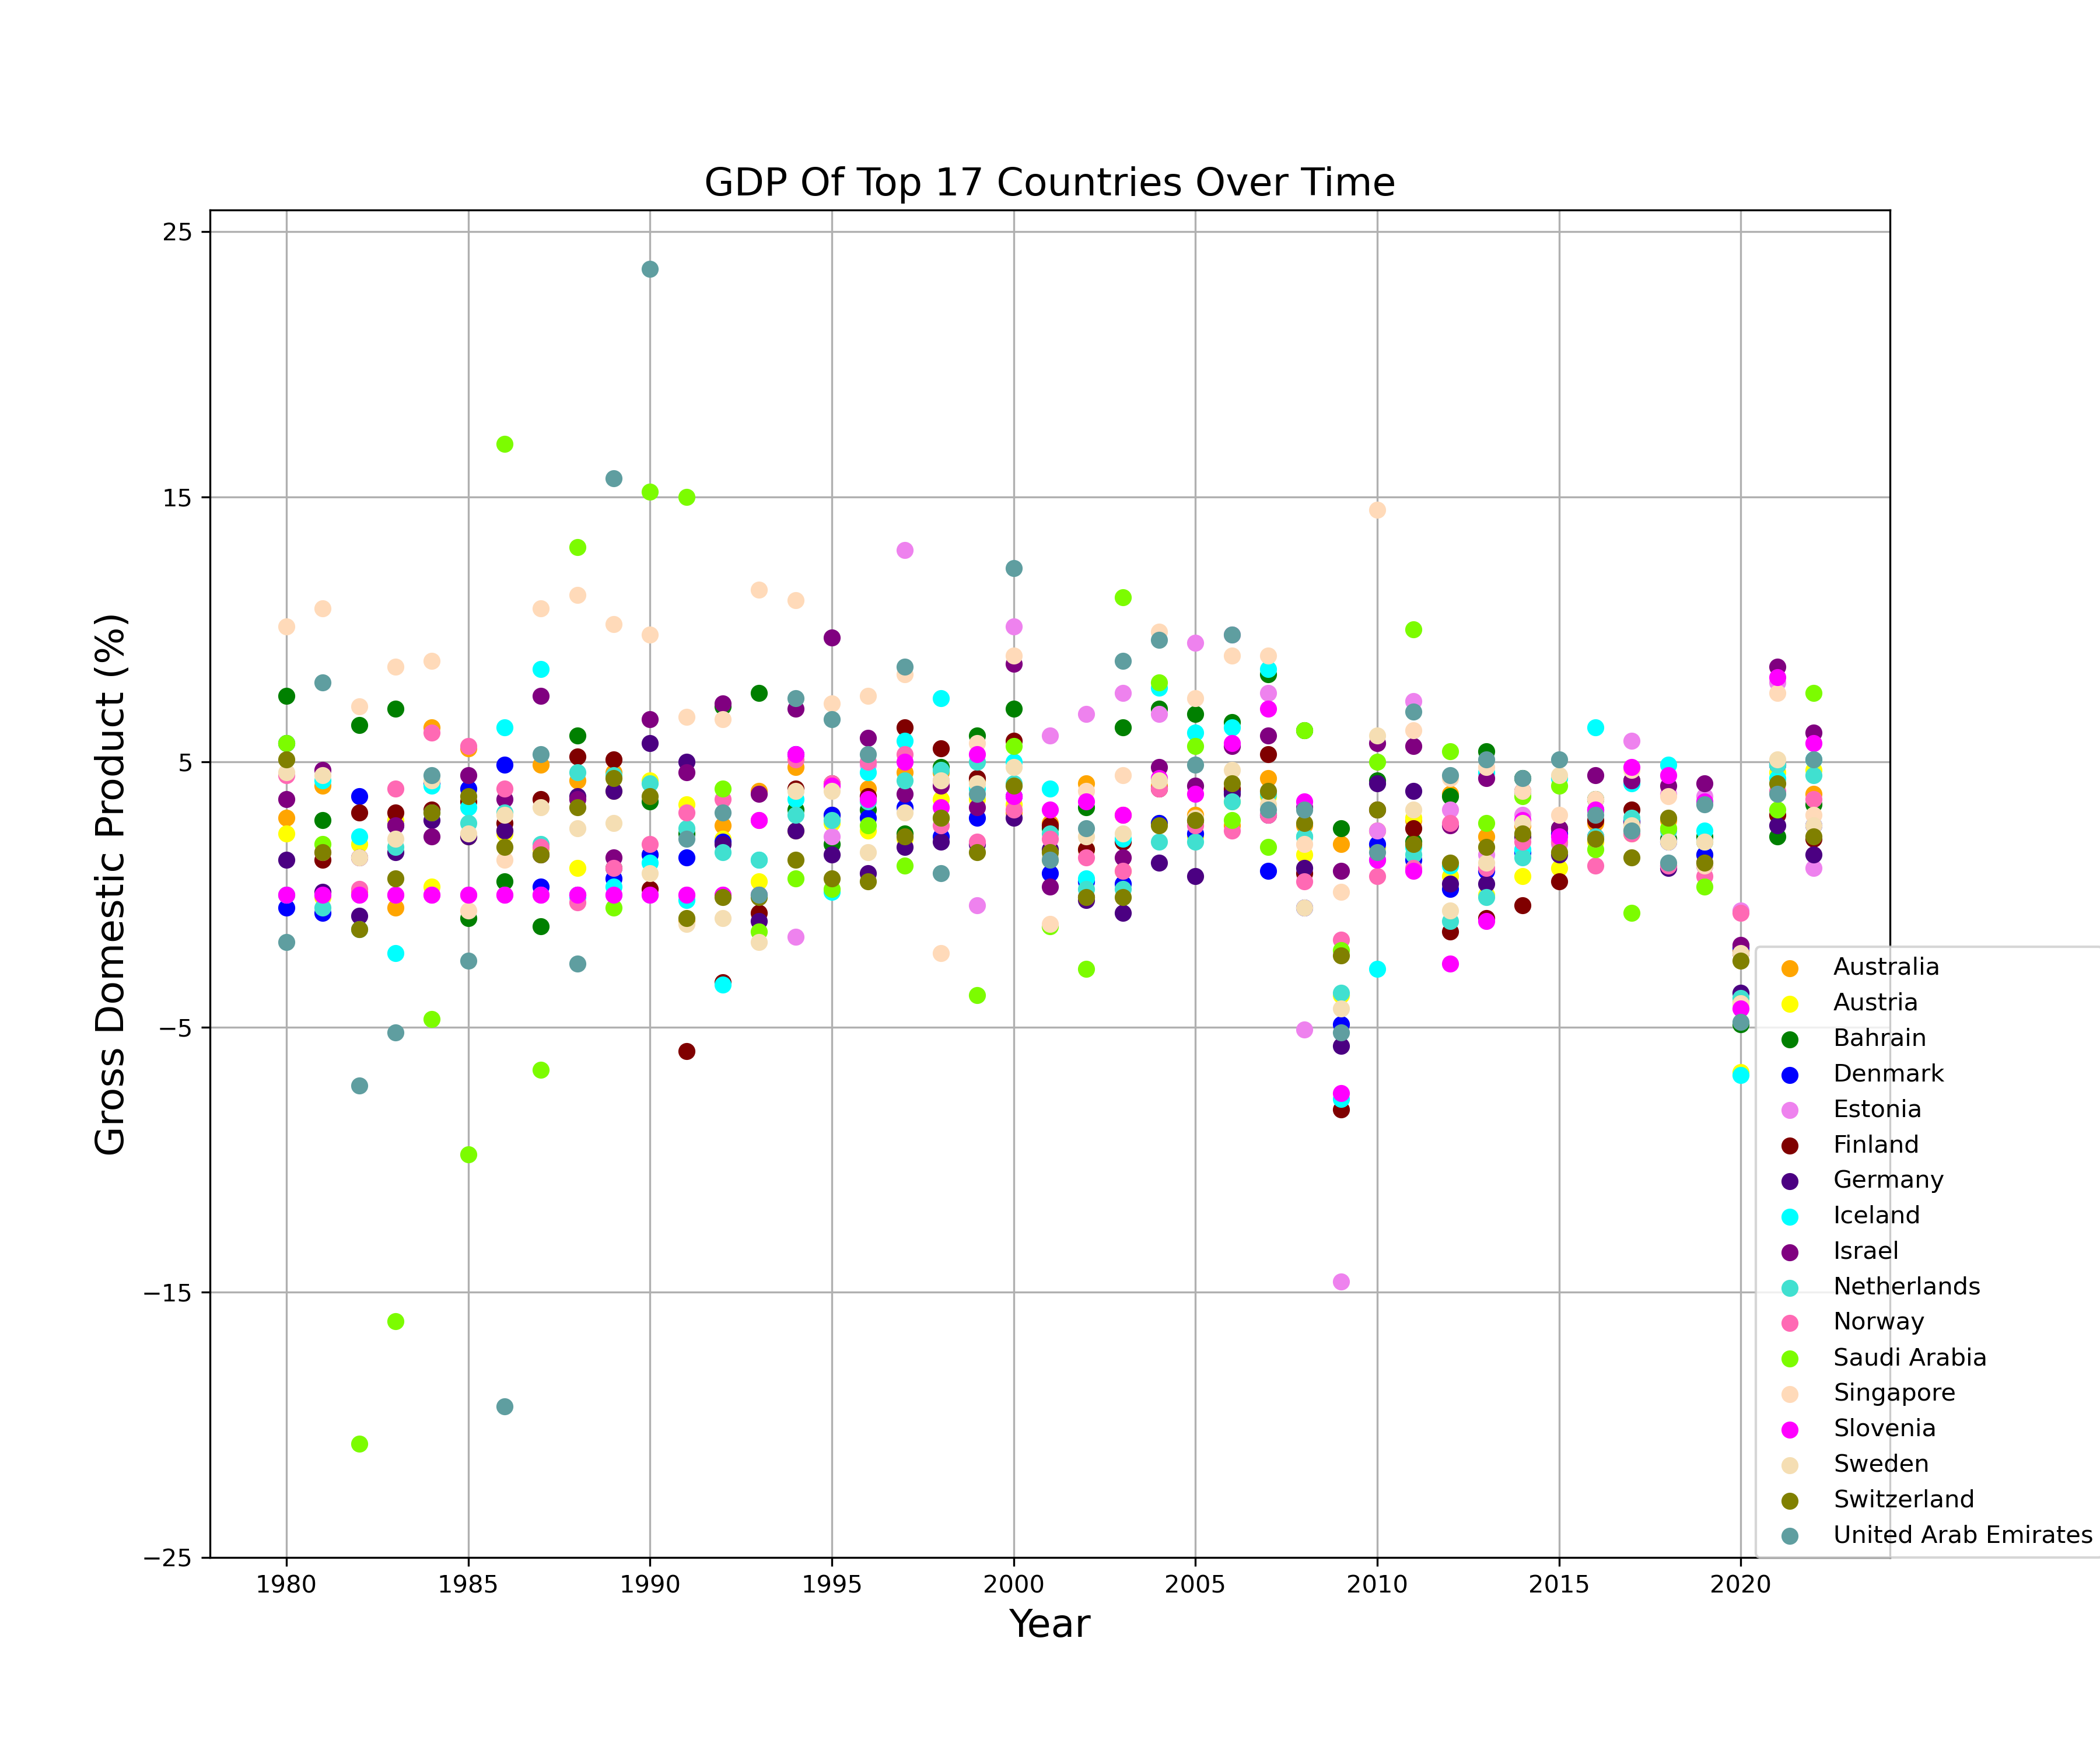

In [64]:
# Sorting countriesOfInterestSet
countriesOfInterestSet = sorted(countriesOfInterestSet)

# Plotting countriesOfInterestSet by GDP
fig, ax = plt.subplots(figsize=(12,10))

fl_fgdp_df = fgdp_df.iloc[:,1:].astype('float')

count = 0
countifs = 0

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet', 'maroon', 'indigo', 
          'aqua', 'purple', 'turquoise', 'hotpink', 'lawngreen', 'peachpuff', 'magenta', 'wheat', 'olive', 'cadetblue']

for x in fgdp_df['Country']:
    if x in countriesOfInterestSet:
        countifs += 1
        ax.scatter(fgdp_df.columns[1:], fl_fgdp_df.iloc[count].tolist(), label=x, zorder = 3, color = colors[countifs])
    count += 1

plt.subplots_adjust(left=0.1)
plt.title(f'GDP Of Top {countriesOfInterestLen} Countries Over Time', fontsize=16)
plt.xticks(fgdp_df.columns[1:][::5])
plt.yticks(range(-25, 30, 10))
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Gross Domestic Product (%)', fontsize = 16)
plt.legend(loc=(0.92, 0))
plt.grid(zorder=0)
fig1 = plt.gcf()
plt.show()

In [65]:
# Create png name
figureTitle = f'GDPTop{countriesOfInterestLen}_16'

# Save the figure
fig1.savefig(f"Output/{figureTitle}.png")

<IPython.core.display.Javascript object>


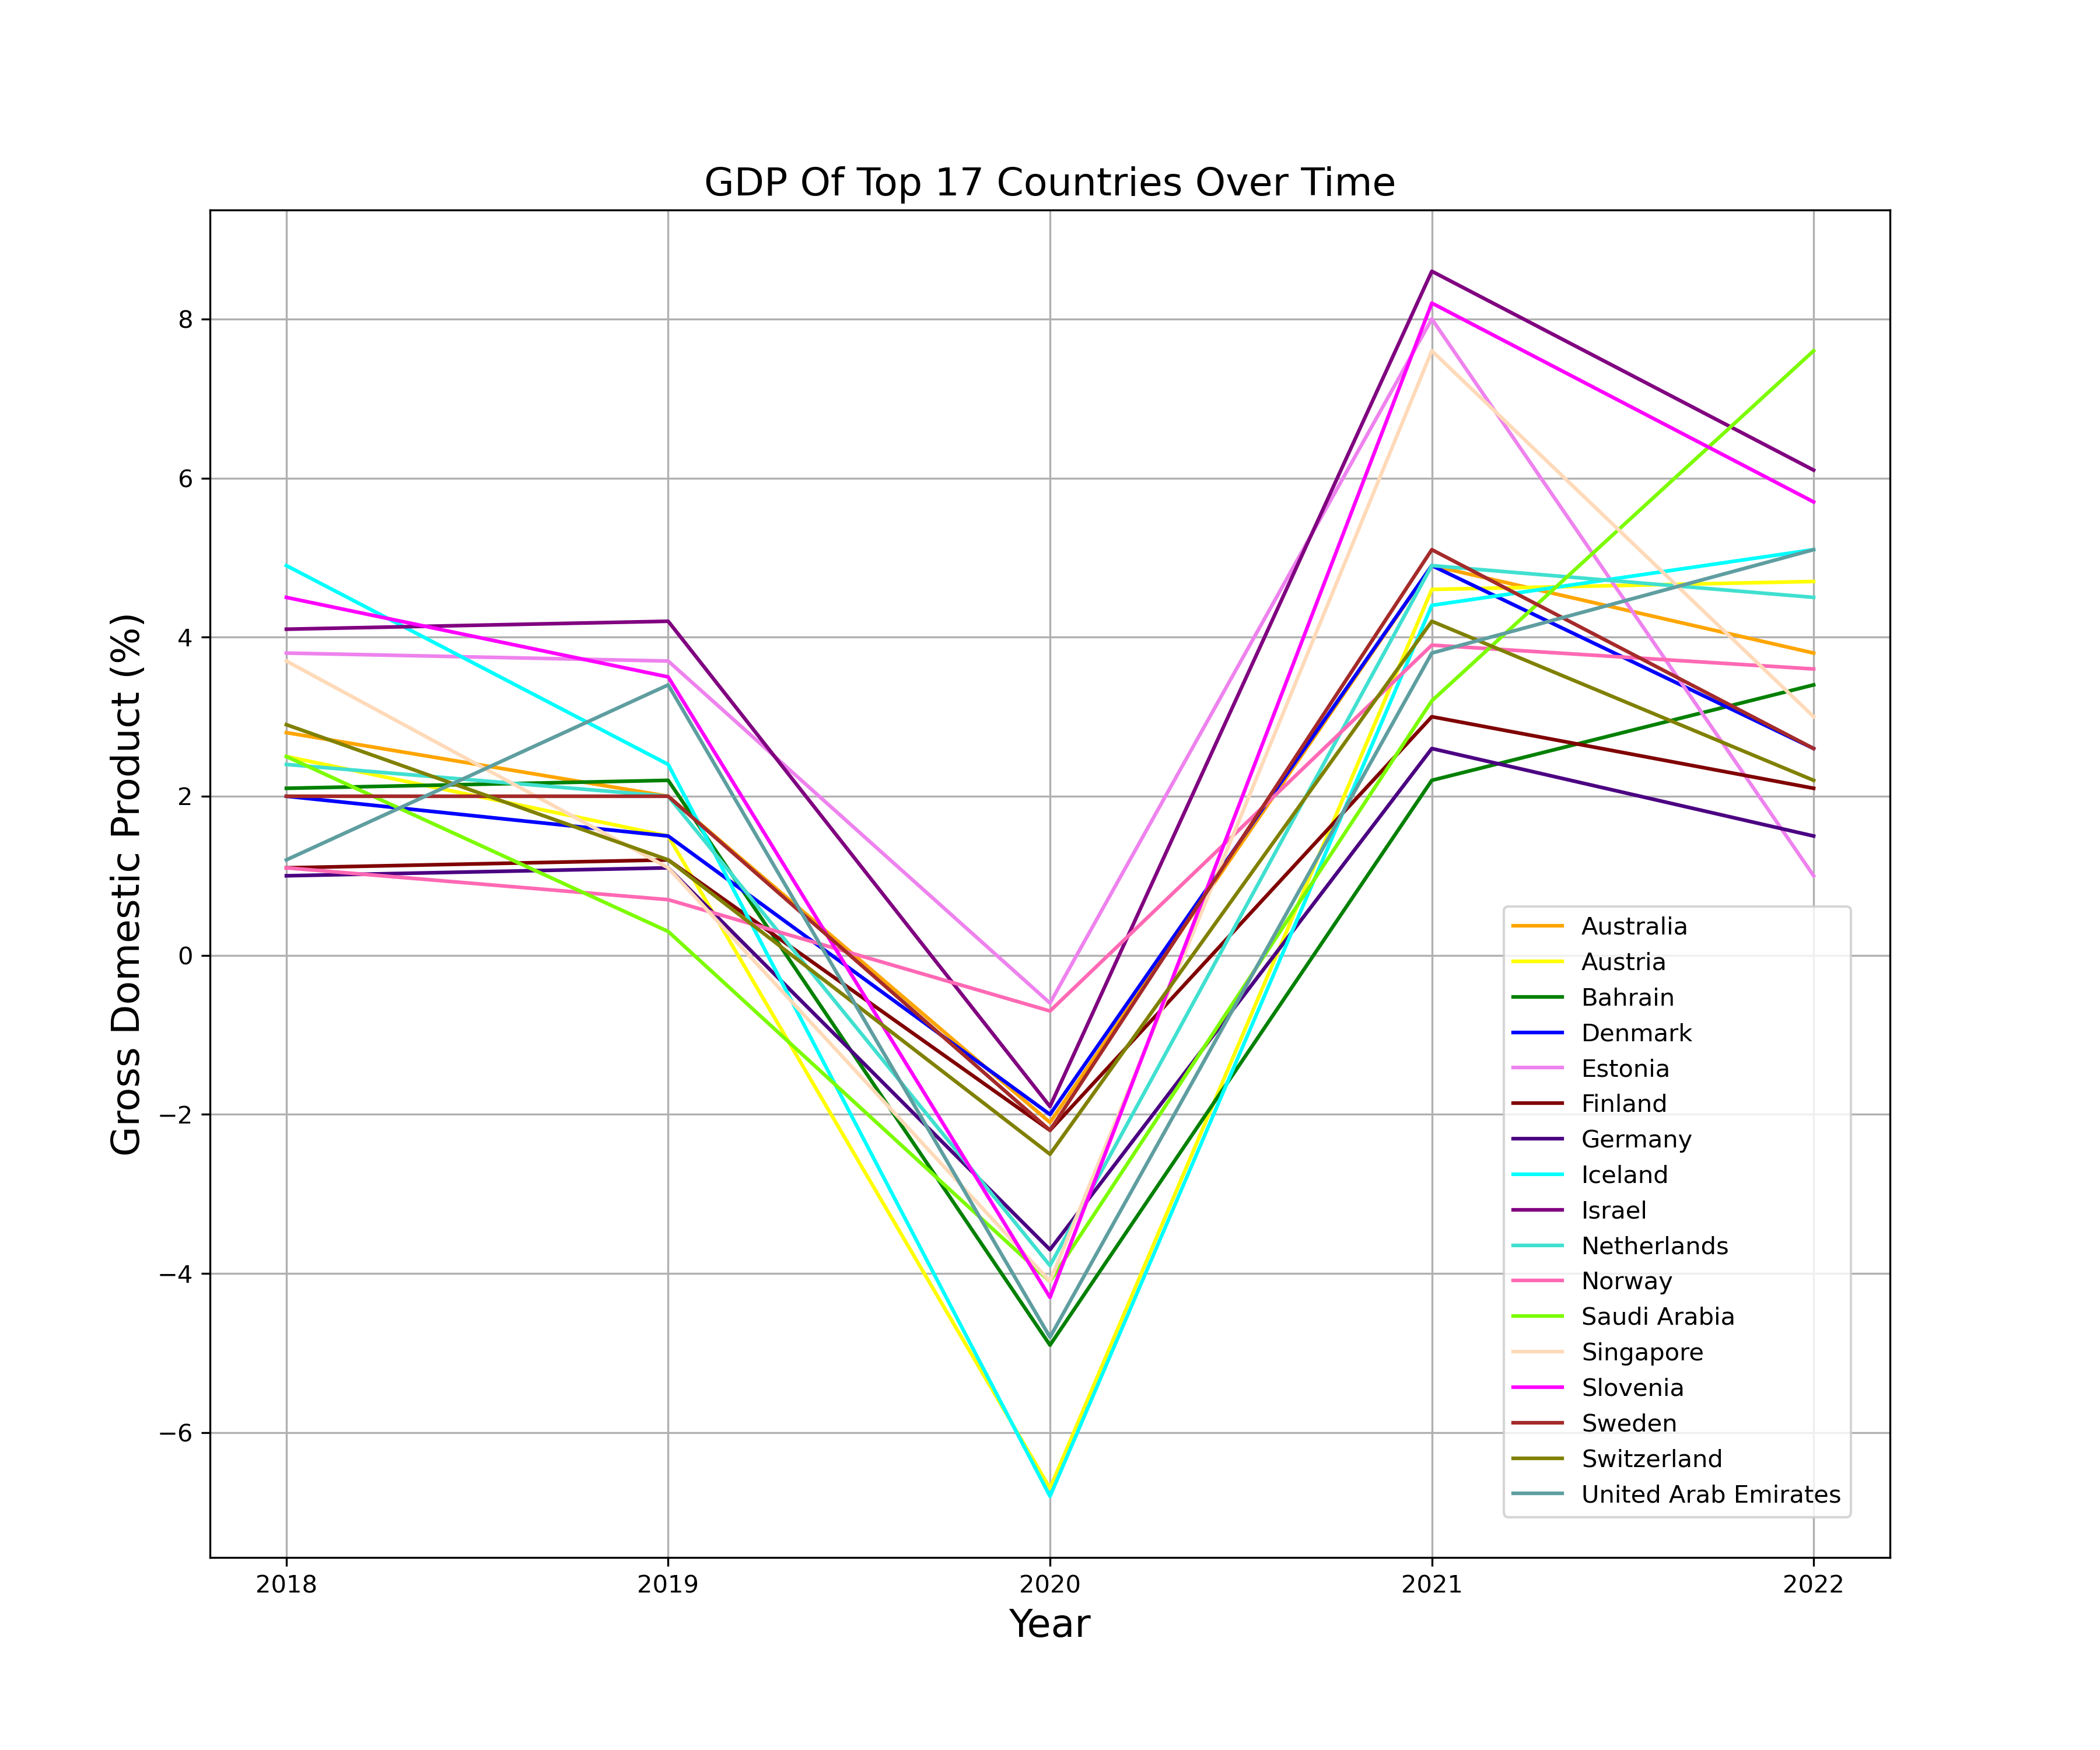

In [66]:
# Plotting countriesOfInterestSet by GDP
fig, ax = plt.subplots(figsize=(12,10))

fl_fgdp_df = fgdp_df.iloc[:,1:].astype('float')

count = 0
countifs = 0

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet', 'maroon', 'indigo', 
          'aqua', 'purple', 'turquoise', 'hotpink', 'lawngreen', 'peachpuff', 'magenta', 'brown', 'olive', 'cadetblue']

for x in fgdp_df['Country']:
    if x in countriesOfInterestSet:
        countifs += 1
        ax.plot(fgdp_df.columns[39:], fl_fgdp_df.iloc[count].tolist()[38:], label=x, zorder = 3, color = colors[countifs])
    count += 1

plt.subplots_adjust(left=0.1)
plt.title(f'GDP Of Top {countriesOfInterestLen} Countries Over Time', fontsize=16)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Gross Domestic Product (%)', fontsize = 16)
plt.legend(loc=(0.77, 0.03))
plt.grid(zorder=0)
fig1 = plt.gcf()
plt.show()

In [67]:
# Create png name
figureTitle = f'GDPTop{countriesOfInterestLen}Last5Years_17'

# Save the figure
fig1.savefig(f"Output/{figureTitle}.png")

In [68]:
# Save dataFrame to csv
fgdp_df.to_csv('./Output/CSVSavePoint/fl_fgdp_df.csv')

In [69]:
#********************************************
# Create a dataframe loading point in order to skip steps in the event of having to restart the kernel
fl_fgdp_df = pd.read_csv('./Output/CSVSavePoint/fl_fgdp_df.csv')

# Load countriesOfInterestSet
with open('./Output/CSVSavePoint/countriesOfInterestSet.txt', 'r') as file:
    countriesOfInterestSet = set(file.read().replace(", ",",").split(",")) 
countriesOfInterestLen = len(countriesOfInterestSet)     
countriesOfInterestSet

{'Australia',
 'Austria',
 'Bahrain',
 'Denmark',
 'Estonia',
 'Finland',
 'Germany',
 'Iceland',
 'Israel',
 'Netherlands',
 'Norway',
 'Saudi Arabia',
 'Singapore',
 'Slovenia',
 'Sweden',
 'Switzerland',
 'United Arab Emirates'}